# DeckDetect

Este proyecto tiene como objetivo detectar y reconocer automáticamente cartas de la **baraja de póker** a partir de una imagen tomada con una cámara o cargada desde un archivo. El sistema identifica cada carta visible en la imagen, extrae su contenido y determina su número (valor) y su palo (símbolo).

### Objetivos principales:
- Detectar todas las cartas visibles en una imagen.
- Corregir la perspectiva para obtener una vista frontal de cada carta.
- Ajustar la orientación para que el número y el símbolo estén correctamente posicionados.
- Extraer las regiones correspondientes al número y al palo.
- Comparar dichas regiones con plantillas de referencia.
- Identificar y clasificar cada carta según su valor y su palo.

### Baraja utilizada:
Se utiliza la baraja estándar de póker:
- **13 valores (ranks):** Ace, Two, Three, ..., Ten, Jack, Queen, King.
- **4 palos (suits):** Clubs, Diamonds, Hearts, Spades.

### Flujo de procesamiento:
1. **Preprocesamiento de imagen:** conversión a escala de grises, detección de bordes y dilatación.
2. **Detección de cartas:** identificación de contornos con forma cuadrilátera.
3. **Transformación de perspectiva:** recorte alineado de cada carta.
4. **Corrección de orientación:** rotación para asegurar que el número esté arriba a la izquierda.
5. **Extracción de número y símbolo:** recorte de la esquina superior izquierda.
6. **Comparación con plantillas:** búsqueda del número y símbolo más parecidos.
7. **Resultado final:** identificación completa de la carta (por ejemplo, "King of Hearts").

### 1. Preparación entorno

Importamos las librerías necesarias: OpenCV para procesamiento de imágenes, NumPy para operaciones matemáticas, Matplotlib para visualizar, y glob/os para gestionar archivos.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

### 2. Preprocesamiento de las cartas

Esta función convierte una imagen a escala de grises, la suaviza, detecta bordes con Canny, y luego los refuerza con dilatación.

In [5]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

Aqui tenemos un pequeño ejemplo para ver su funcionamiento:

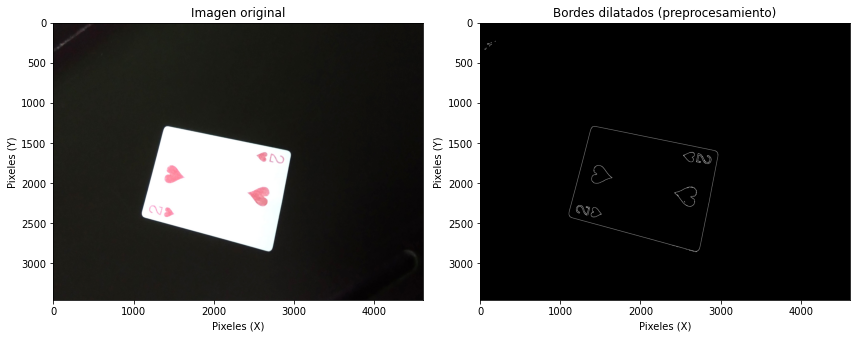

In [29]:
img = cv2.imread("Fotos/Imagenes/2H27.jpg")
edges = preprocess_image(img)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagen original")
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Bordes dilatados (preprocesamiento)")
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()


### 3. Ordenar esquinas del contorno

Cuando detectamos una carta, sus 4 esquinas pueden estar en cualquier orden. Esta función reorganiza esos puntos para que siempre estén en el orden correcto:

1. **Top-left**
2. **Top-right**
3. **Bottom-right**
4. **Bottom-left**

Esto es esencial para poder aplicar correctamente una transformación de perspectiva más adelante. También incluye una verificación extra por si se detectan coordenadas duplicadas (poco común, pero posible).

In [10]:
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect

### 4. Transformación de perspectiva (warp)

Una vez tenemos los 4 puntos de una carta en el orden correcto, esta función "endereza" la carta como si la viéramos desde arriba.

Pasos que realiza:

1. Calcula las dimensiones reales de la carta usando distancias entre esquinas.
2. Define una nueva cuadrícula rectangular para la carta ya rectificada.
3. Aplica una transformación de perspectiva para que la carta aparezca derecha y recortada.

Resultado: una imagen limpia, alineada y lista para analizar su contenido (número y palo).


In [9]:
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

### 5. Corrección de orientación de la carta

Esta función verifica si la carta se encuentra en la orientación adecuada, es decir, con el número y el símbolo en la esquina superior izquierda.

Para ello, realiza hasta cuatro rotaciones de 90 grados (0°, 90°, 180°, 270°), evaluando en cada paso si la orientación es correcta.

En cada rotación:
- Se extrae una pequeña región de la esquina superior izquierda (ROI).
- La región se convierte a escala de grises, se binariza y se suaviza morfológicamente.
- Se buscan contornos que cumplan con ciertos criterios de área y proporción, los cuales se asumen como posibles número o símbolo.

Si se encuentra al menos un contorno válido, se considera que la carta está en la orientación correcta y se devuelve. En caso contrario, la imagen se rota y se repite el proceso.

Si no se detecta una orientación válida después de cuatro intentos, se devuelve la imagen en su última rotación.

Cuando el parámetro `debug` está activado, se muestran visualizaciones intermedias del proceso.


In [23]:
def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]
    roi_h, roi_w = int(h * 0.2), int(w * 0.15)

    for i in range(4):
        roi = card_img[0:roi_h, 0:roi_w]
        
        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
            
        if roi is None or roi.size == 0:
            print("⚠️ ROI vacío. No se puede convertir a escala de grises.")
            return None  # o manejarlo como prefieras
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (5, 5), 0)
        bin_roi = binarize_region(gray, block_size=10, C=2, blur_ksize=5, use_clahe=True)
        bin_roi = morphological_smoothing(bin_roi)
        
        if debug:
            plt.figure(figsize=(4, 4))
            plt.imshow(cv2.cvtColor(bin_roi, cv2.COLOR_BGR2RGB))
            plt.title("ROI")
            plt.axis("off")
            plt.show()
        contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos pequeños (posibles número y palo)
        filtered = []
        for cnt in contours:
            x, y, wc, hc = cv2.boundingRect(cnt)
            area = wc * hc
            ratio = wc / float(hc) if hc != 0 else 0
            if (300 < area < 15000) and (0.3 < ratio < 1.5):  # Rango para número o símbolo, ajustar si necesario                
                filtered.append((x, y, wc, hc))

        # Ordenar por coordenada Y
        filtered = sorted(filtered, key=lambda b: b[1])
    
        if debug:
            # Copia para dibujar
            contour_img = roi.copy()
            for x, y, wc, hc in filtered:
                cv2.rectangle(contour_img, (x, y), (x + wc, y + hc), (0, 255, 0), 1)
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Contornos detectados - Rotación {i*90}°")
            plt.axis("off")
            plt.show()
    
        if len(filtered) >= 1:
            #print("i:", i*90)
            return card_img  

        # ❌ No parece la orientación correcta, rotamos
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)
        #print("i:", i*90, " | filtered:", filtered)
    return card_img


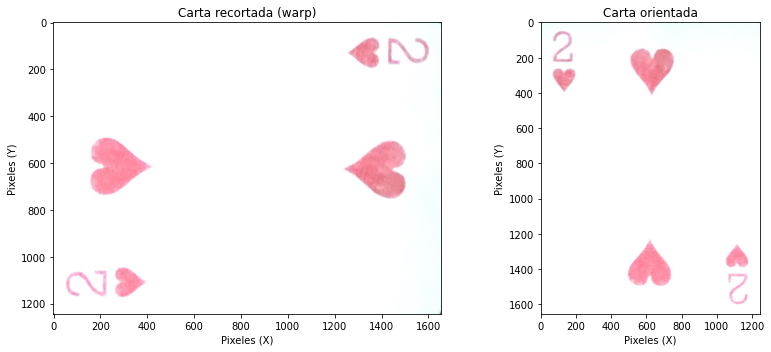

In [31]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Carta recortada (warp)")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(oriented, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Carta orientada")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()


### 6. Detección de contornos de cartas

Una vez tenemos la imagen procesada, buscamos contornos que representen cartas.

- Usamos `cv2.findContours` con `RETR_TREE` para obtener la jerarquía de contornos (útil para descartar los internos).
- Filtramos contornos **externos** y con un **área mínima** para evitar falsos positivos.
- Aplicamos `approxPolyDP` sobre el **convex hull** del contorno para obtener una forma más regular.
- Si el contorno tiene 4 lados, lo consideramos una carta. Si no, usamos un método alternativo (`minAreaRect`) para obtener una caja rectangular aproximada.

Resultado: una lista de contornos que representan cartas detectadas.


In [11]:
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

Aqui tenemos un ejemplo de la función para encontrar los contornos de una carta:

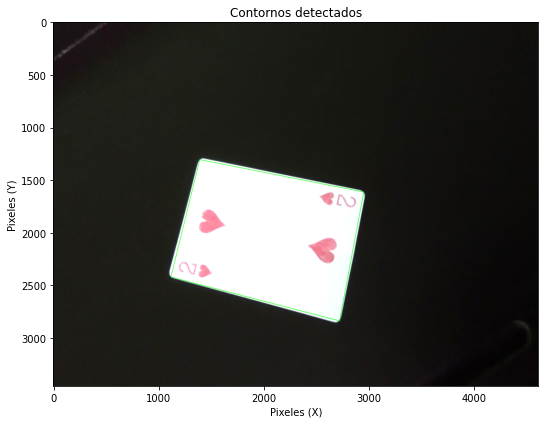

In [38]:
edges = preprocess_image(img)
contornos = find_card_contours(edges)

# Dibujar los contornos detectados sobre una copia de la imagen original
img_contornos = img.copy()
cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 3)

# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Contornos detectados")
plt.xlabel("Pixeles (X)")
plt.ylabel("Pixeles (Y)")
plt.tight_layout()
plt.show()

### 7. Extracción del número y símbolo de la carta

Esta función se encarga de identificar y extraer la región donde se encuentra el número (rango) y el símbolo (palo) de la carta, generalmente ubicados en la esquina superior izquierda.

Pasos que realiza:

1. Se recorta una región de interés (ROI) desde la esquina superior izquierda de la carta. Esta región cubre aproximadamente el 25% de la altura y el 18% del ancho de la imagen. Estos valores pueden ajustarse si es necesario.
2. Se convierte la región a escala de grises, se mejora su contraste y se binariza usando un umbral adaptativo.
3. Se aplica suavizado morfológico para limpiar la imagen.
4. Se detectan contornos externos y se seleccionan los dos más grandes, asumiendo que corresponden al número y al palo.
5. Se ordenan los contornos de arriba hacia abajo (por coordenada vertical), y cada uno se recorta y redimensiona:
   - El primer contorno se considera el número.
   - El segundo contorno se considera el palo.
6. Si se encuentra exactamente un número y un palo, ambos se devuelven como imágenes separadas. En caso contrario, se devuelve `None`.

Si `debug=True`, se muestran visualizaciones del ROI, la binarización y las regiones recortadas del número y símbolo para facilitar la depuración.


In [12]:
def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    # 🔍 Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.18)]  # Ajustable si hace falta más ancho o alto
    
    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("Crop Esquina Superior Izquierda (ROI)")
        plt.axis("off")
        plt.show()
    
    # 🔎 Detectar contornos
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=30, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)
    # _, bin_roi = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # orden vertical

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                cv2.imshow("Debug Crop", joined)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]

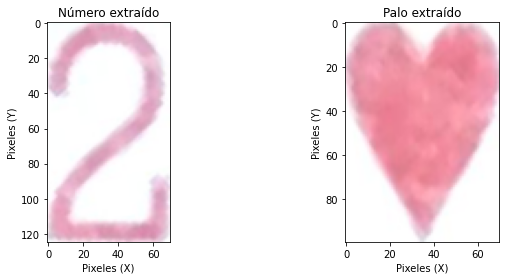

In [32]:
number_img, suit_img = extract_number_suit_region(oriented)

if number_img is not None and suit_img is not None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(cv2.cvtColor(number_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Número extraído")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(suit_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Palo extraído")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()


### 8. Binarización de una región

Esta función convierte una región (en escala de grises o en color) en una imagen binaria, donde los elementos relevantes (como números o símbolos) quedan en blanco sobre fondo negro.

Pasos que realiza:

1. Asegura que los parámetros `block_size` y `blur_ksize` sean impares, ya que así lo requiere OpenCV.
2. Convierte la región a escala de grises si aún no lo está.
3. Aplica CLAHE (opcional, pero activado por defecto) para mejorar el contraste local, útil cuando la imagen tiene iluminación desigual.
4. Suaviza la imagen con un desenfoque gaussiano para reducir el ruido.
5. Aplica un umbral adaptativo con inversión (`THRESH_BINARY_INV`), lo que resalta las zonas oscuras sobre fondo claro.

Este proceso mejora la segmentación de caracteres y símbolos para su posterior análisis.


In [13]:
def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1

    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

### 9. Suavizado morfológico

Esta función aplica operaciones morfológicas sobre una imagen binaria para mejorar su limpieza y legibilidad.

Pasos que realiza:

1. **Cierre morfológico (`MORPH_CLOSE`)**: rellena pequeños huecos negros dentro de áreas blancas.
2. **Apertura morfológica (`MORPH_OPEN`)**: elimina puntos blancos aislados que puedan considerarse ruido.

El resultado es una imagen binaria más limpia, ideal para una detección de contornos más precisa. Se utiliza comúnmente después de la binarización para mejorar la calidad de las regiones a analizar.


In [14]:
def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

### 10. Utilidades para preparar imágenes y plantillas

Estas funciones se encargan de normalizar, binarizar o redimensionar imágenes para que puedan ser comparadas correctamente con las plantillas.

- `resize_for_template(img, template_shape)`: redimensiona una imagen para que tenga el mismo tamaño que una plantilla.
- `normalize_for_template(img)`: aplica desenfoque y normalización de intensidad, útil en ciertos casos para estandarizar imágenes antes de comparar.
- `binarize_template(template)`: convierte una plantilla en imagen binaria mediante umbralado fijo. Asume que los elementos están sobre fondo blanco y no se invierte el resultado.


In [16]:
def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

### 11. Verificación de contenido en una región

La función `region_has_rank_or_suit` se utiliza para comprobar si una región (por ejemplo, una esquina de la carta) contiene información relevante como un número o un símbolo.

Para ello:
- Convierte la región a escala de grises.
- Calcula la desviación estándar de la intensidad (para medir variación).
- Cuenta la cantidad de píxeles "oscuros".

Devuelve `True` si la variación y la cantidad de píxeles oscuros superan ciertos umbrales, lo que indica que probablemente hay contenido gráfico en la región.


In [17]:
def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels

### 12. Carga de plantillas de números y palos

La función `load_templates` carga todas las plantillas de números y símbolos desde la carpeta `Fotos/Plantillas`.

- Busca todos los archivos `.jpg` cuyo nombre comience con el nombre del número o palo (`Ace`, `Two`, `Clubs`, etc.).
- Cada plantilla se carga en escala de grises y se almacena en un diccionario con su nombre como clave.

Devuelve dos diccionarios:
- `number_templates`: para comparar números.
- `suit_templates`: para comparar palos.


In [34]:
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates

### 13. Comparación de una región con plantillas

La función `match_template` compara una región de una carta (como el número o el símbolo) con un conjunto de plantillas precargadas.

Pasos que realiza:
1. Binariza y suaviza la región objetivo.
2. Para cada plantilla del conjunto:
   - Se binariza.
   - Se redimensiona la región objetivo al tamaño de la plantilla.
   - Se calcula una correlación normalizada (`cv2.matchTemplate`) para comparar similitud.
3. Se selecciona la plantilla con mayor puntuación como resultado.

Opcionalmente, se pueden mostrar las imágenes comparadas si `debug=True`.


In [18]:
def match_template(region, templates, debug=False):
    binary = binarize_region(region)
    binary = morphological_smoothing(binary)
    
    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            templ_bin = binarize_template(template)
            # templ_bin = normalize_for_template(templ_bin)

            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            if debug:
                # Mostrar REGION (izquierda)
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(binary, cmap='gray')
                plt.title("Recorte de la carta")
                plt.axis("off")

                # Mostrar TEMPLATE (derecha)
                plt.subplot(1, 2, 2)
                plt.imshow(templ_bin, cmap='gray')  # ya es binarizada
                plt.title(f"Template: {name}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()


            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)
            if debug:
                print(f"{name}: score = {max_val:.4f}")

            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name

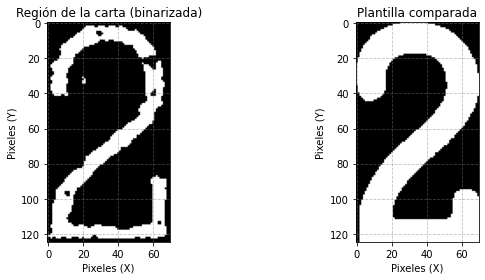

In [36]:
number_templates, suit_templates = load_templates()
templ_bin = binarize_template(number_templates['Two'][0])
resized = cv2.resize(binarize_region(number_img), (templ_bin.shape[1], templ_bin.shape[0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(resized, cmap='gray')
axs[0].set_title("Región de la carta (binarizada)")
axs[0].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(templ_bin, cmap='gray')
axs[1].set_title("Plantilla comparada")
axs[1].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()


### 14. Validación de proporción de la carta

La función `is_valid_card_proportion` verifica si la carta rectificada tiene una proporción (alto/ancho) razonable.

Esto sirve para descartar deformaciones por errores en el proceso de recorte o warping.

La proporción esperada es aproximadamente 1:1. Se permite un margen (`jump_ratio`) para evitar rechazar cartas ligeramente distorsionadas.

Devuelve `True` si la proporción está dentro del rango aceptable.


In [ ]:
def is_valid_card_proportion(warped_img, jump_ratio=0.7, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

### 15. Ejecución principal del sistema (`main`)

Esta función coordina todo el flujo del reconocimiento:

1. Carga la imagen desde disco.
2. La preprocesa para detectar bordes.
3. Encuentra los contornos de las cartas.
4. Para cada carta detectada:
   - Se corrige la perspectiva (warp).
   - Se rota para asegurar la orientación correcta.
   - Se valida la proporción.
   - Se extraen las regiones del número y el símbolo.
   - Se comparan estas regiones con plantillas para identificar la carta.

Permite activar modo `debug` para visualizar cada paso.

Devuelve el número y el palo detectados de la primera carta válida encontrada en la imagen.


In [24]:
def main(path, debug=False):
    # === MAIN EXECUTION ===
    image = cv2.imread(path)
    if debug:
        print("Detectando edges")
    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    if debug:
        print("Buscando los contornos de cartas")
    card_contours = find_card_contours(edges)

    # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()
    if debug:
        print("Analizando las cartas")

    number_templates, suit_templates = load_templates()

    for contour in card_contours:
        
        warped = warp_card(image, contour)
        if warped is None:
            if debug:
                print("Obtención de las esquinas fallido")
            continue
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        warped = correct_card_orientation(warped, debug)
        if warped is None:
            if debug:
                print("Orientar la carta fallido")
            continue
            
        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Transformación de la carta")
            plt.show()
            
        # 📐 Verificamos proporción tras warping
        if not is_valid_card_proportion(warped, debug=debug):
            if debug:
                print("⚠️ Proporción de la carta fuera de rango. Saltando...")
            continue

        number_region, suit_region = extract_number_suit_region(warped)

        if number_region is not None and suit_region is not None:
            
            if debug:
                # Mostrar regiones extraídas
                plt.subplot(1,2,1)
                plt.imshow(cv2.cvtColor(number_region, cv2.COLOR_BGR2RGB))
                plt.title("Número")
                plt.subplot(1,2,2)
                plt.imshow(cv2.cvtColor(suit_region, cv2.COLOR_BGR2RGB))
                plt.title("Palo")
                plt.show()

            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)
            if debug:
                print(f"🃏 Card detected: {number} of {suit}")
            return number, suit
        else:
            continue
    if debug:
        print("⚠️ No se pudieron extraer las regiones del número y palo.")
    return None, None


Detectando edges


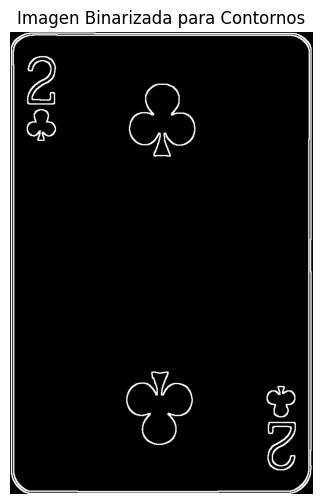

Buscando los contornos de cartas


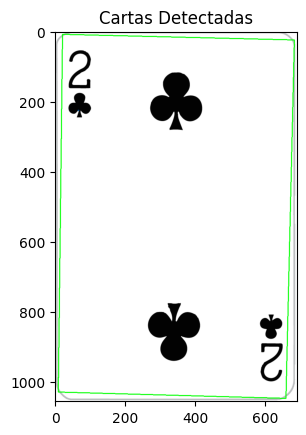

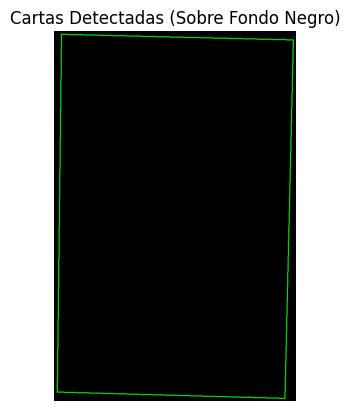

Analizando las cartas


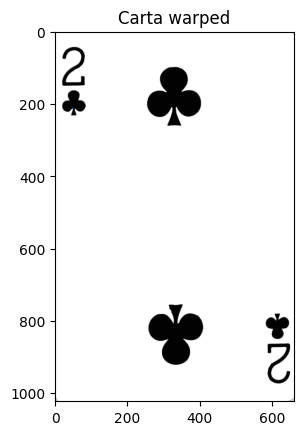

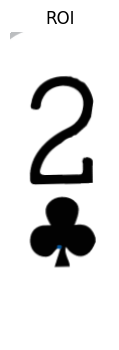

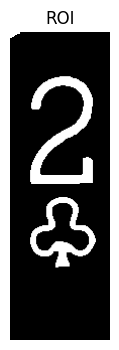

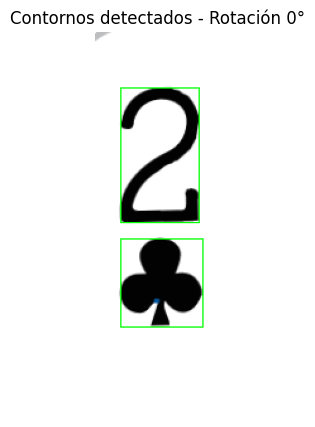

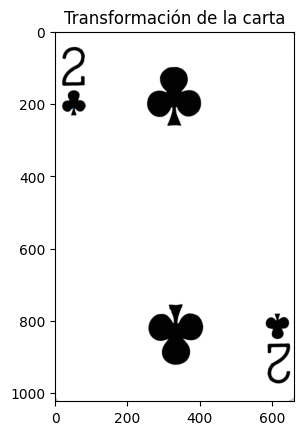

[DEBUG] Dimensiones carta: 662x1023 | Ratio: 1.55 | 0.30000000000000004 <= 1.55 <= 1.7
	Resultado:True


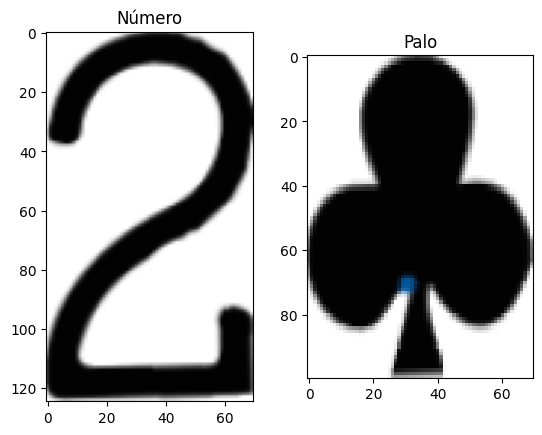

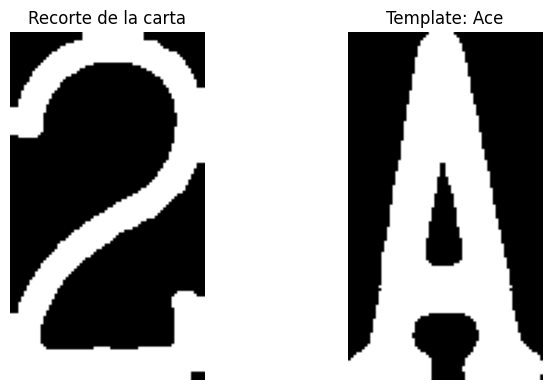

Ace: score = -0.0727


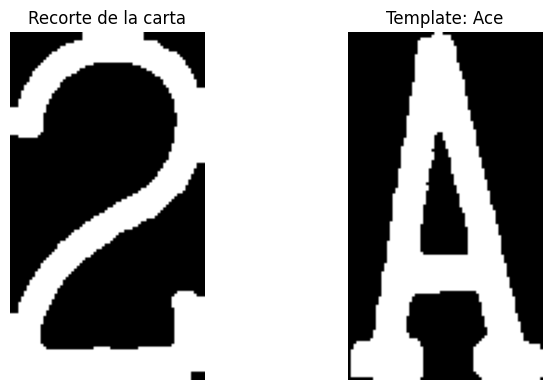

Ace: score = -0.0253


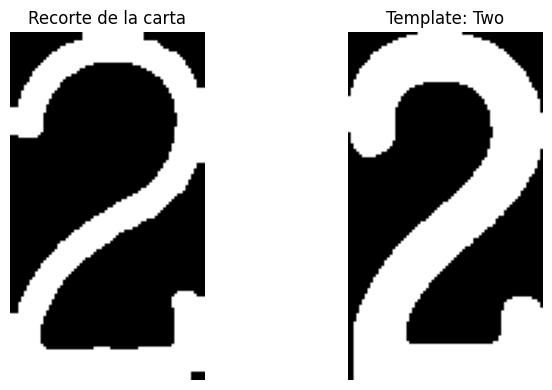

Two: score = 0.6545


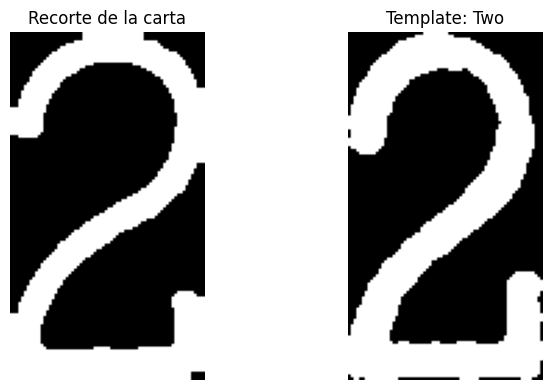

Two: score = 0.6908


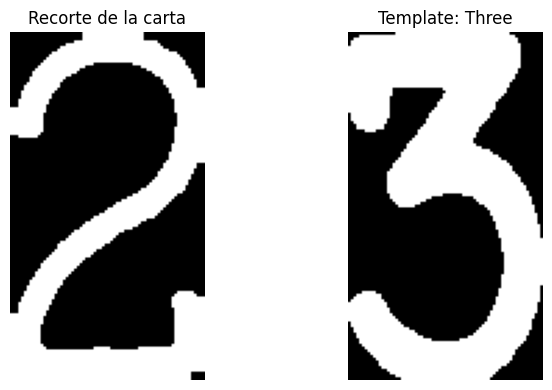

Three: score = 0.0961


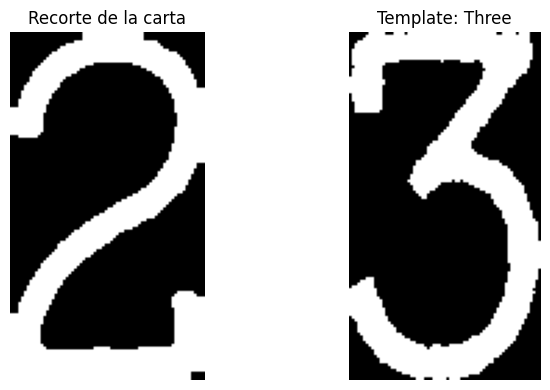

Three: score = 0.1291


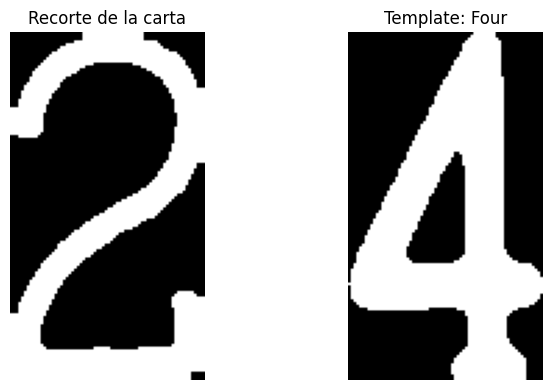

Four: score = -0.2046


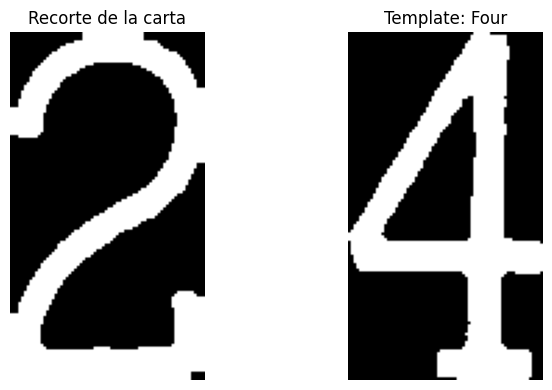

Four: score = -0.1124


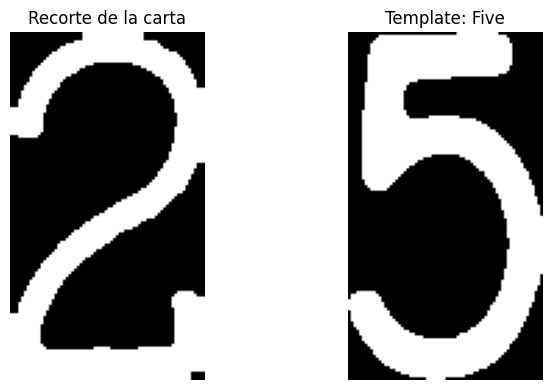

Five: score = 0.0952


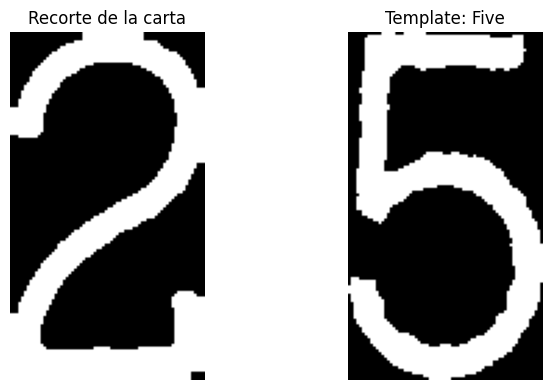

Five: score = 0.1575


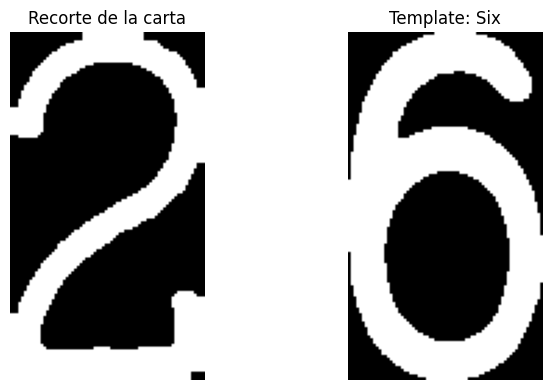

Six: score = 0.0778


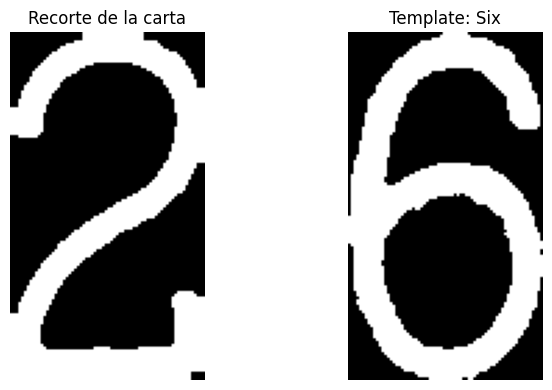

Six: score = 0.1498


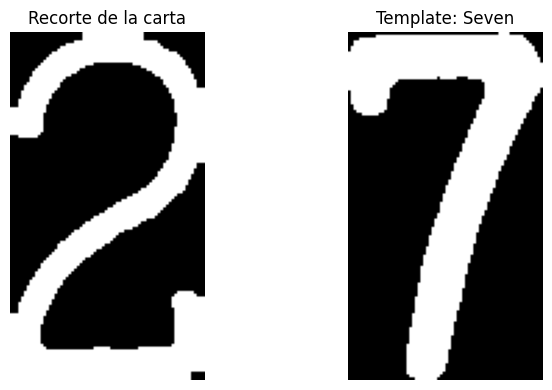

Seven: score = 0.0837


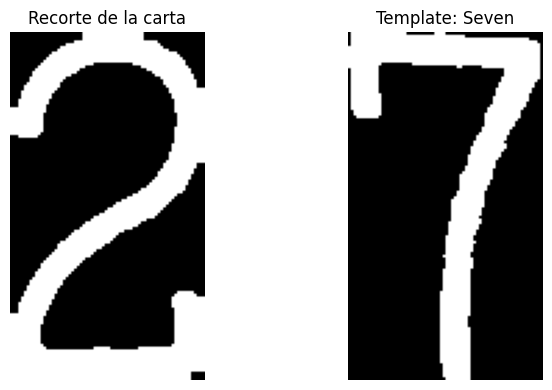

Seven: score = 0.0865


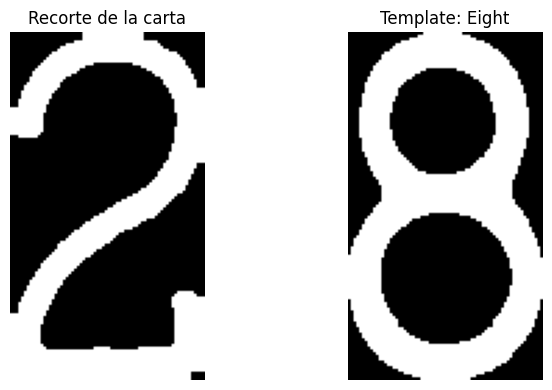

Eight: score = 0.2237


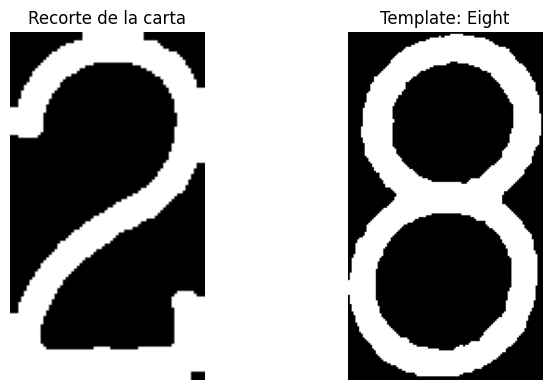

Eight: score = 0.3093


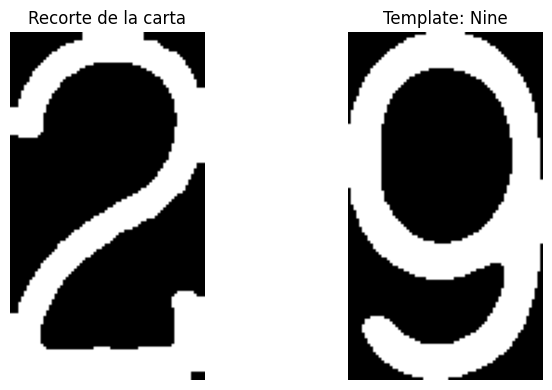

Nine: score = 0.2123


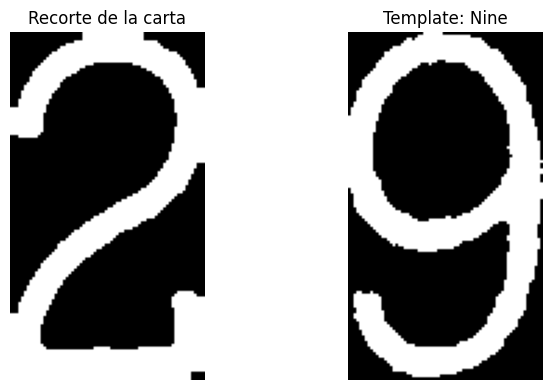

Nine: score = 0.3499


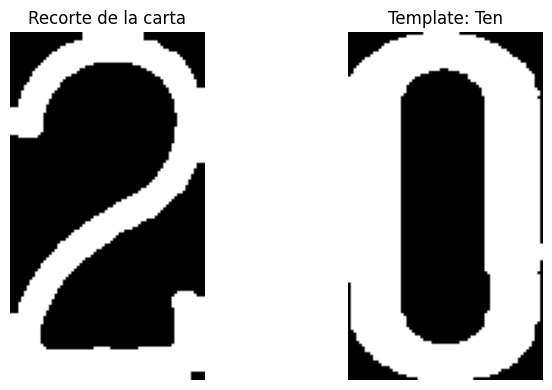

Ten: score = 0.2578


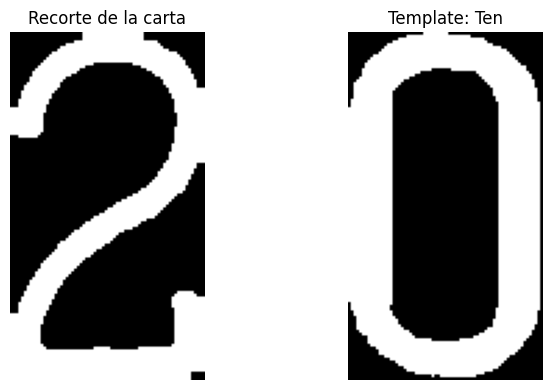

Ten: score = 0.2696


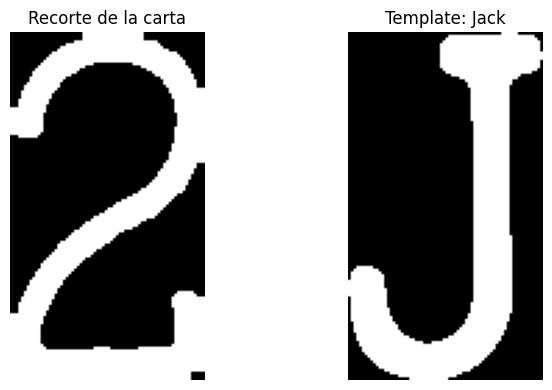

Jack: score = 0.0764


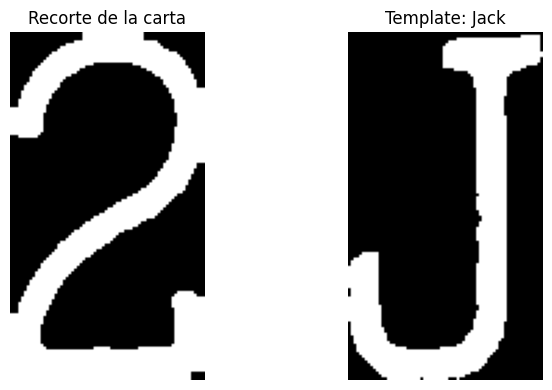

Jack: score = 0.1287


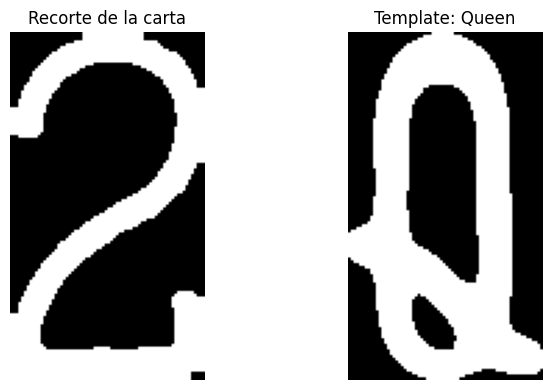

Queen: score = -0.0443


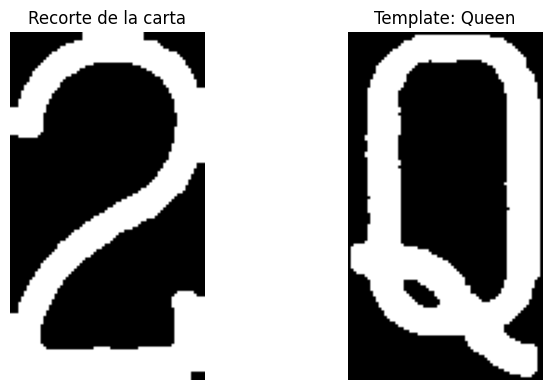

Queen: score = 0.1152


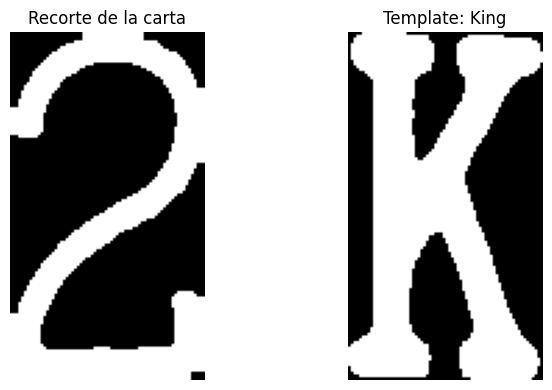

King: score = 0.0425


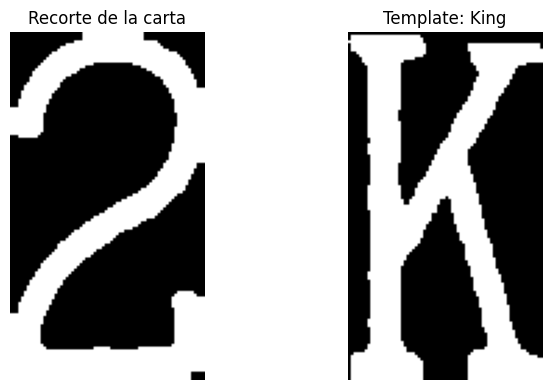

King: score = 0.0700


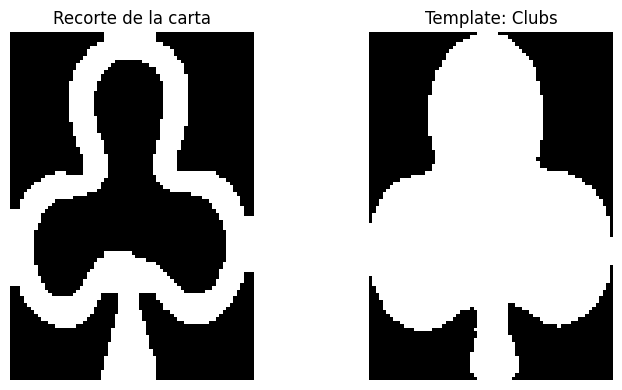

Clubs: score = 0.4860


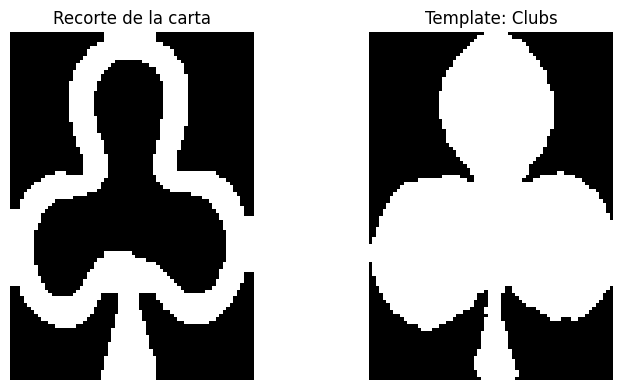

Clubs: score = 0.3780


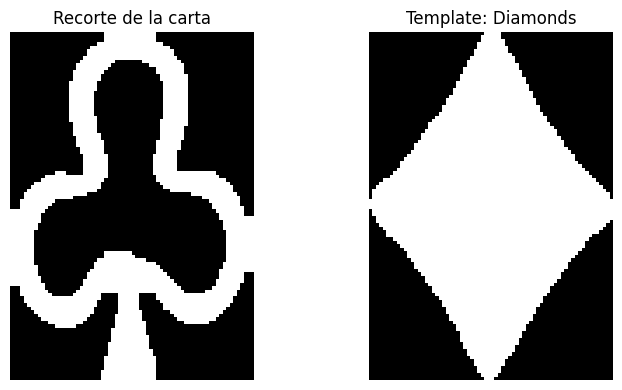

Diamonds: score = 0.1371


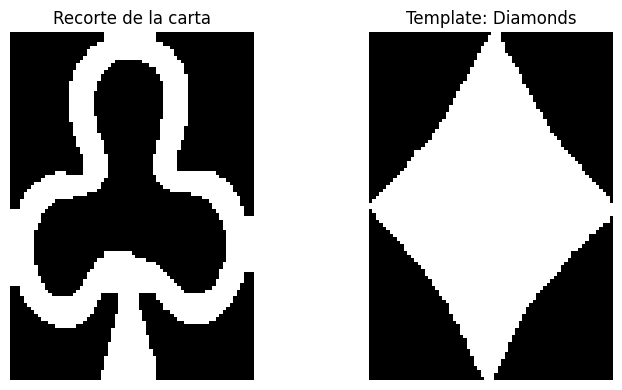

Diamonds: score = 0.1232


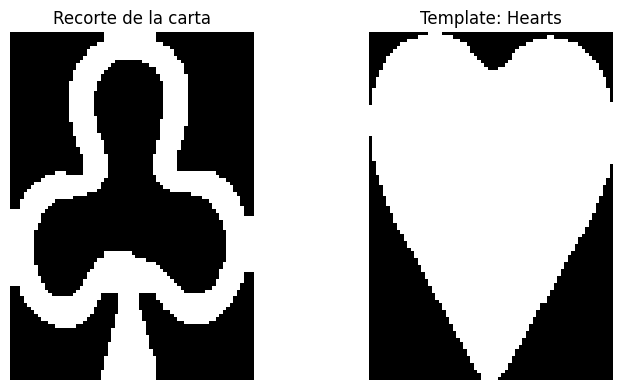

Hearts: score = -0.0263


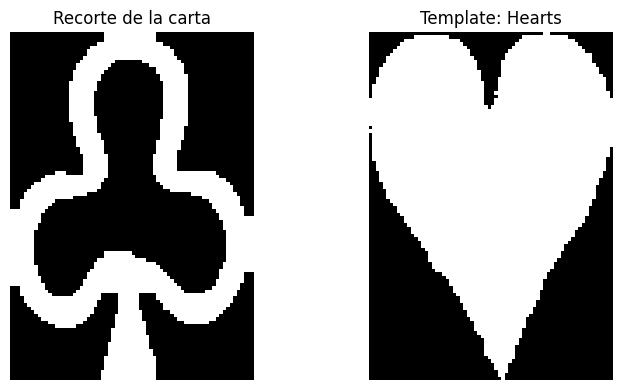

Hearts: score = -0.0371


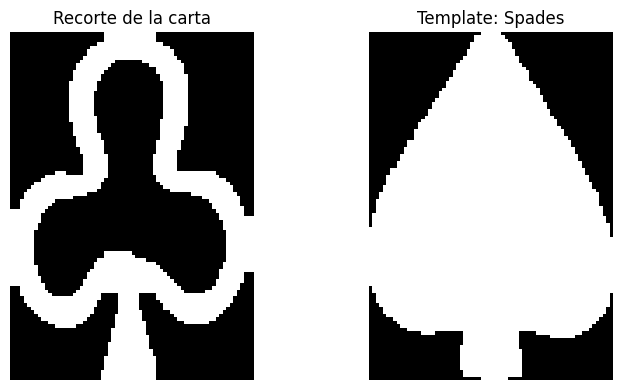

Spades: score = 0.3706


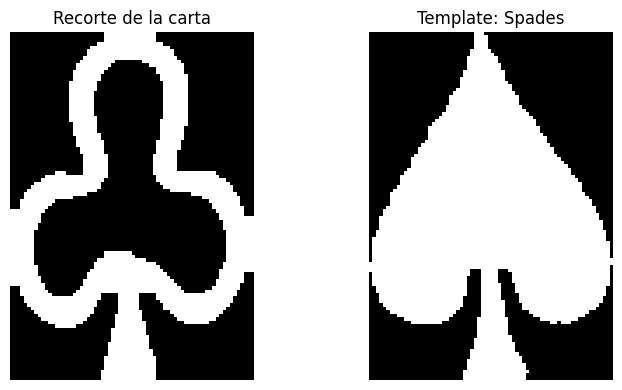

Spades: score = 0.2886
🃏 Card detected: Two of Clubs


('Two', 'Clubs')

In [19]:
main("Fotos/fotos_sencillas/2C.PNG", debug=True)

Detectando edges


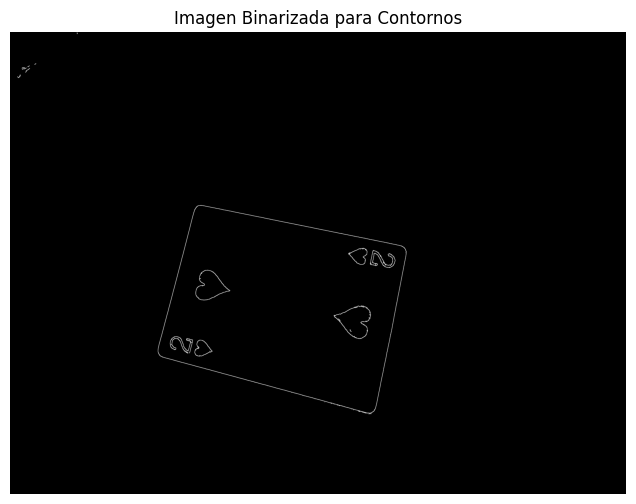

Buscando los contornos de cartas


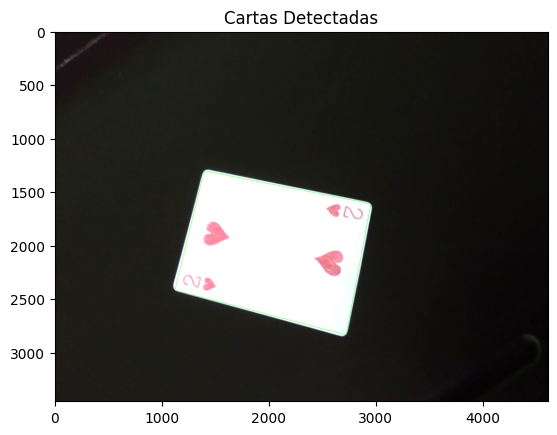

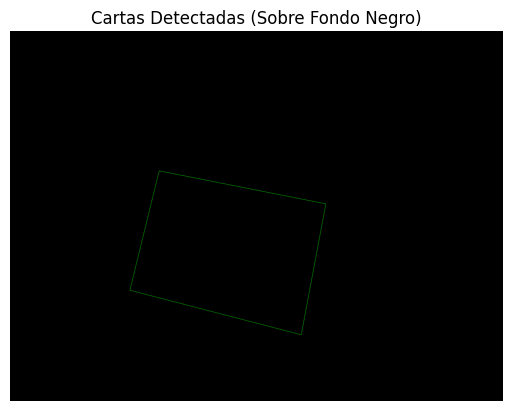

Analizando las cartas


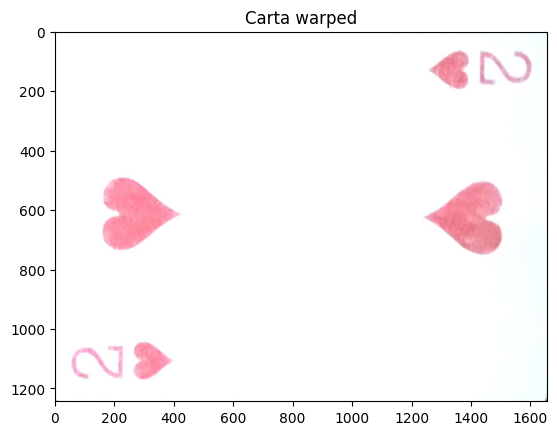

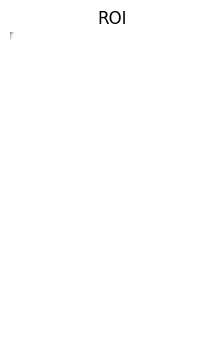

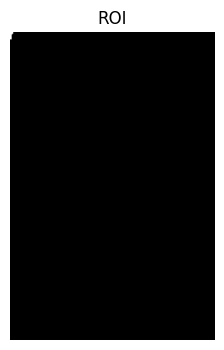

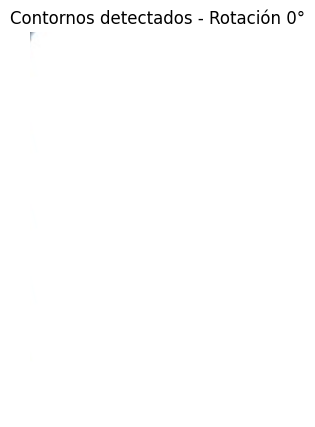

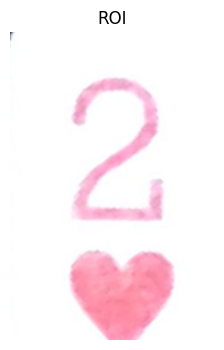

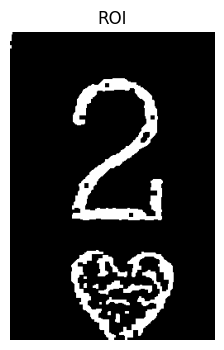

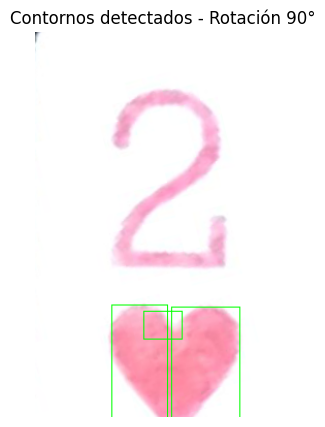

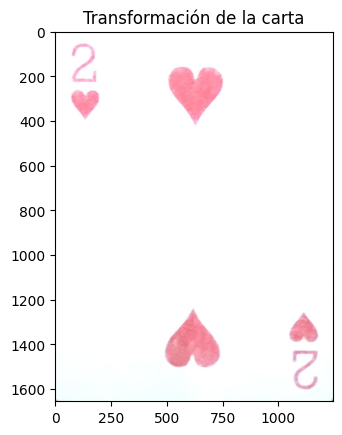

[DEBUG] Dimensiones carta: 1244x1655 | Ratio: 1.33 | 0.30000000000000004 <= 1.33 <= 1.7
	Resultado:True


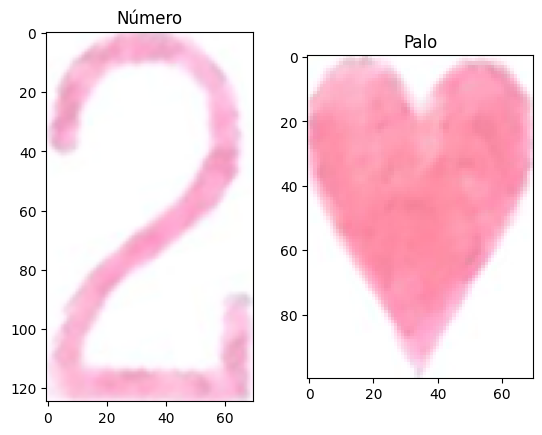

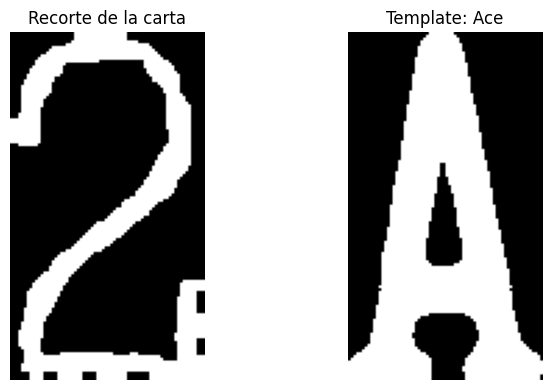

Ace: score = -0.0604


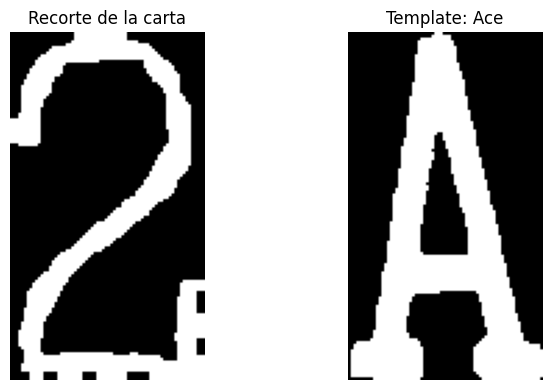

Ace: score = -0.0157


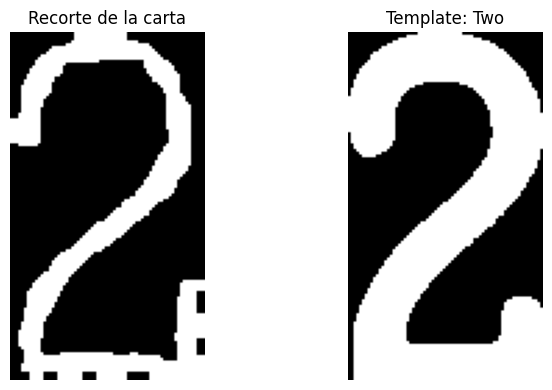

Two: score = 0.5972


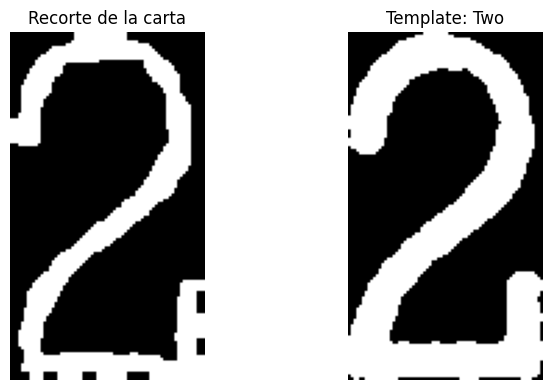

Two: score = 0.7074


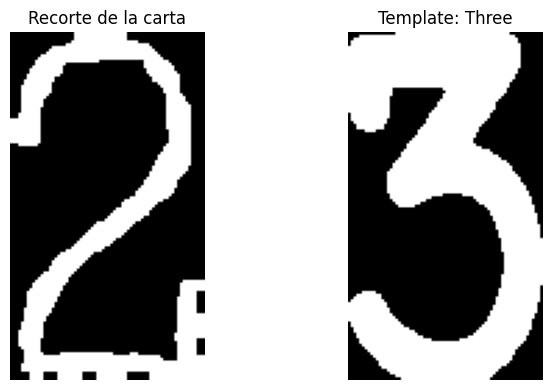

Three: score = 0.1101


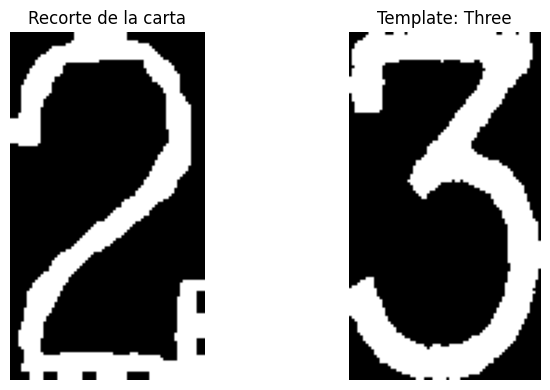

Three: score = 0.1629


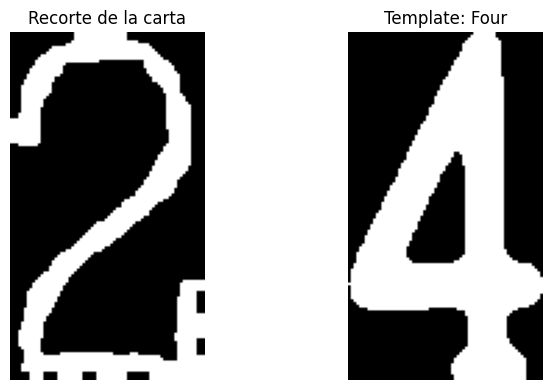

Four: score = -0.1488


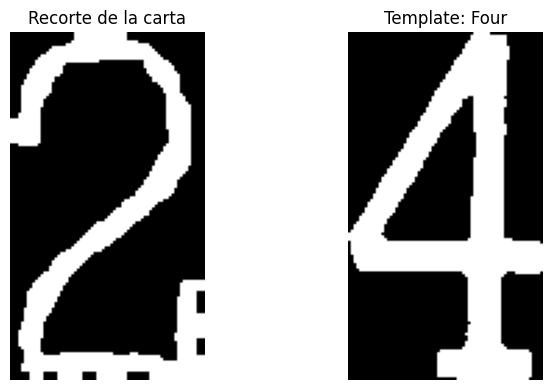

Four: score = -0.0812


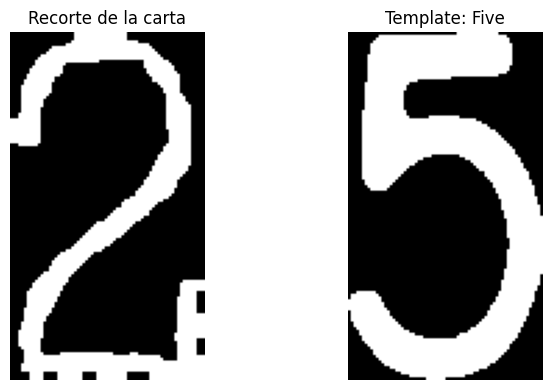

Five: score = 0.1261


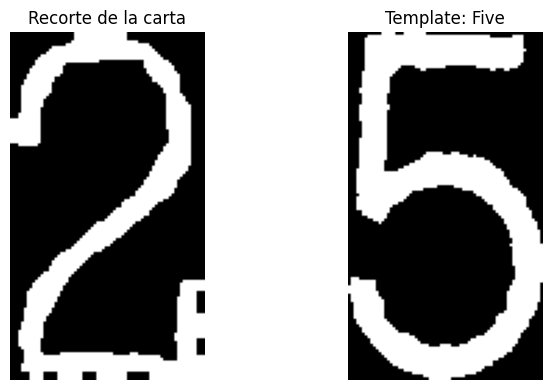

Five: score = 0.1834


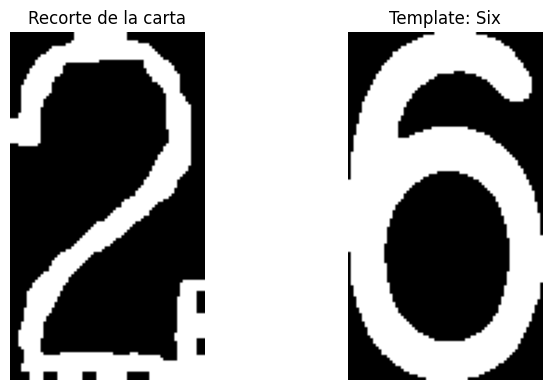

Six: score = 0.0847


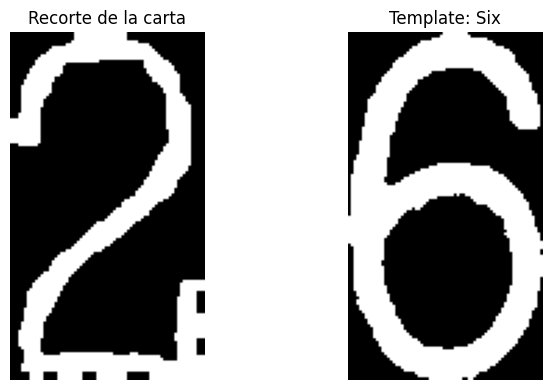

Six: score = 0.1253


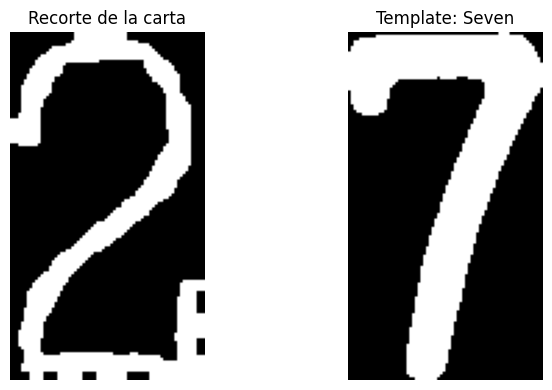

Seven: score = 0.1404


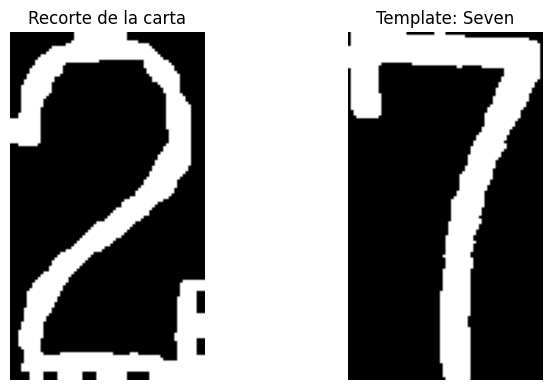

Seven: score = 0.1387


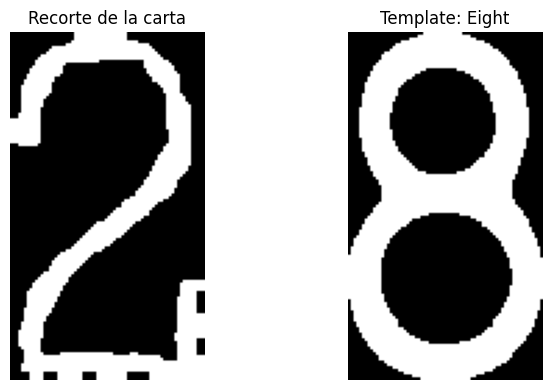

Eight: score = 0.2913


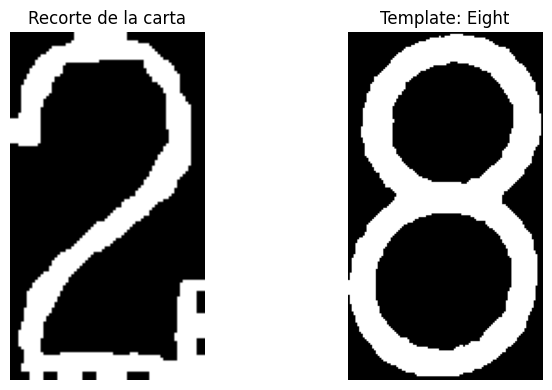

Eight: score = 0.2589


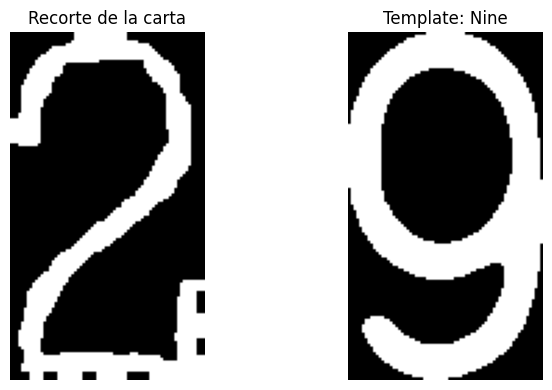

Nine: score = 0.2120


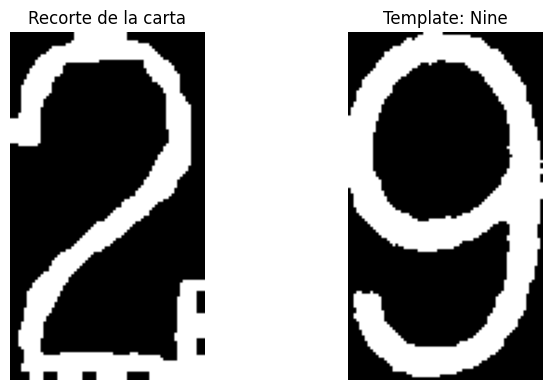

Nine: score = 0.3424


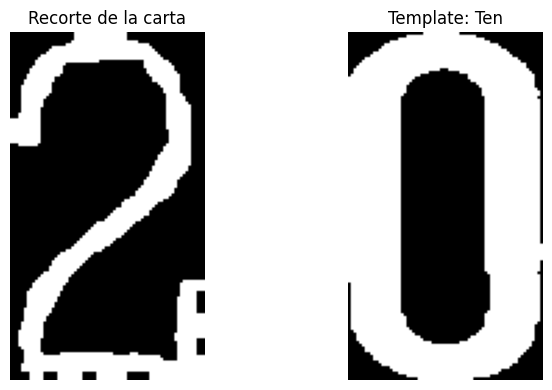

Ten: score = 0.2471


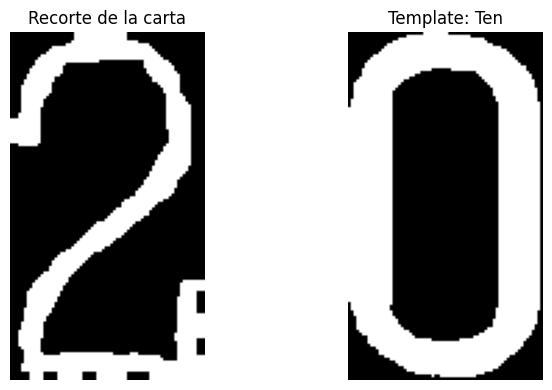

Ten: score = 0.2478


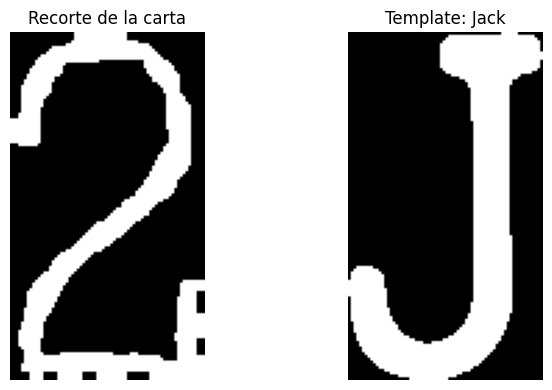

Jack: score = 0.0958


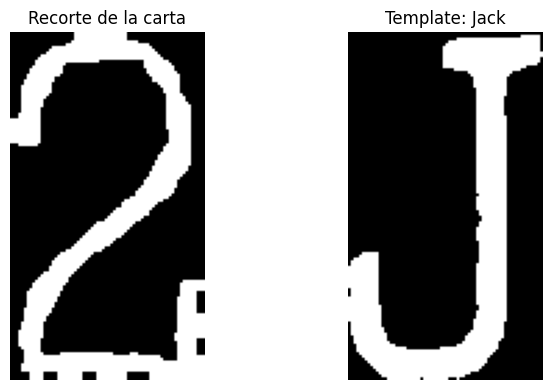

Jack: score = 0.1149


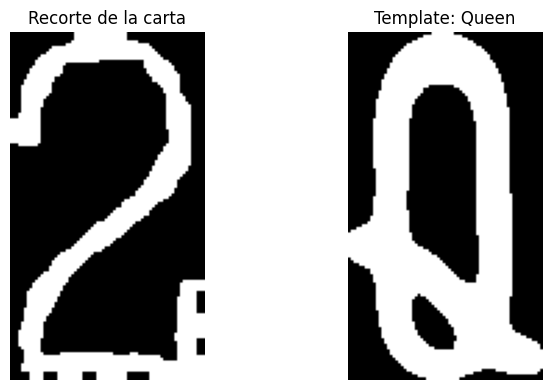

Queen: score = 0.0151


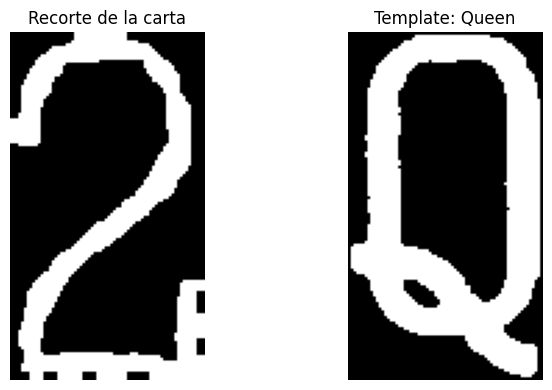

Queen: score = 0.0808


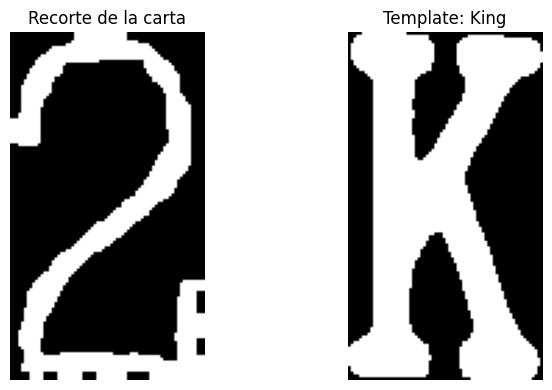

King: score = 0.0229


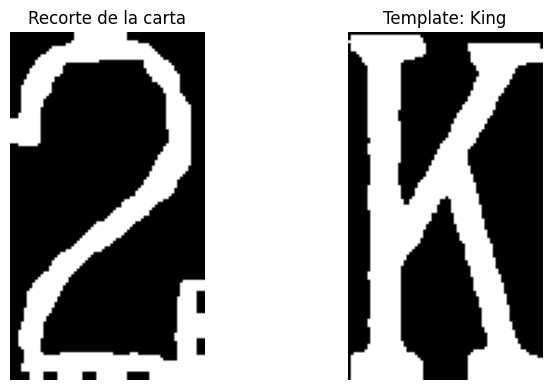

King: score = 0.0786


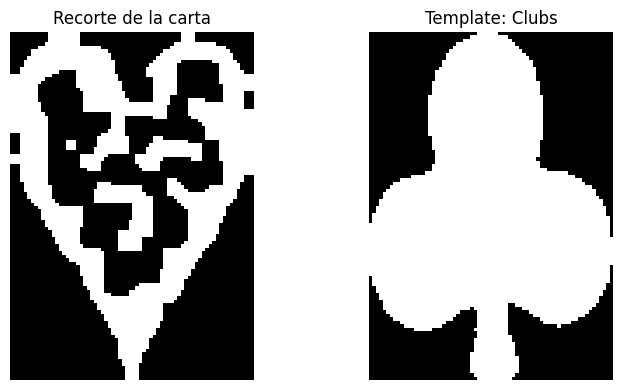

Clubs: score = 0.0380


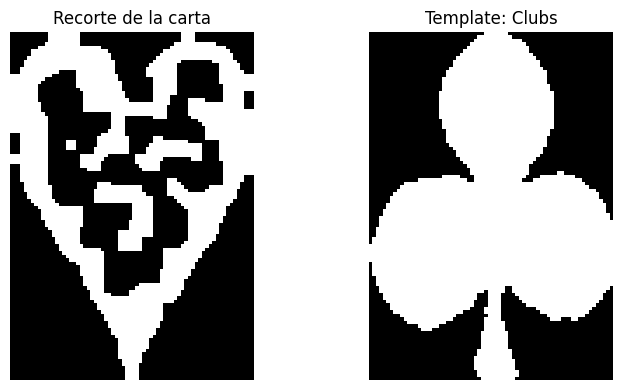

Clubs: score = 0.0337


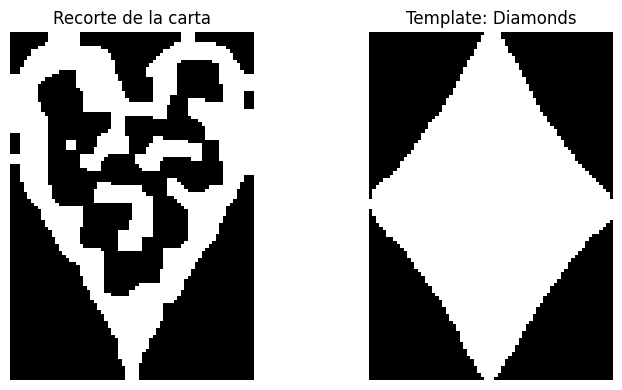

Diamonds: score = 0.1689


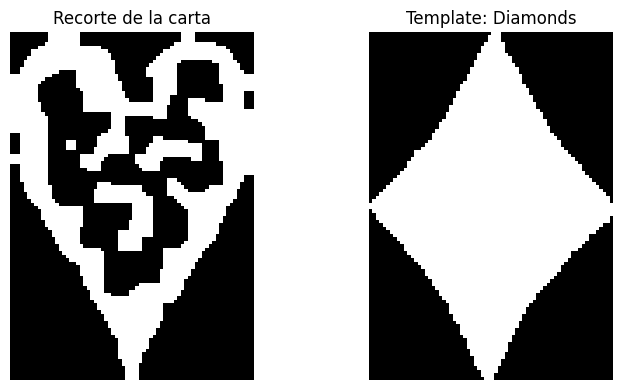

Diamonds: score = 0.1923


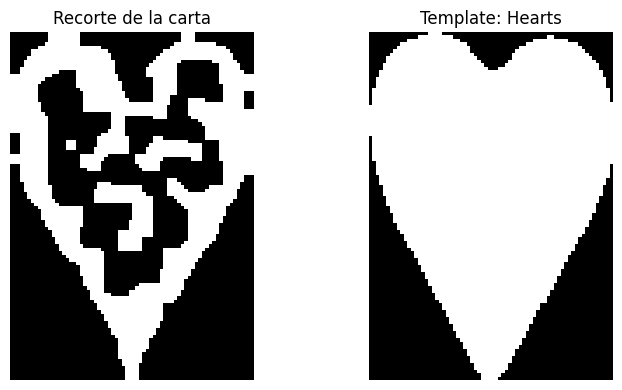

Hearts: score = 0.5089


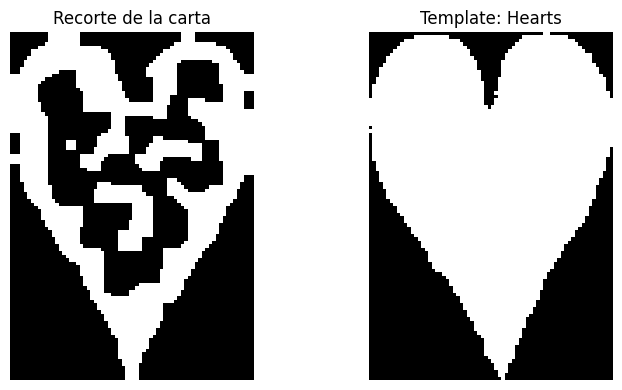

Hearts: score = 0.5171


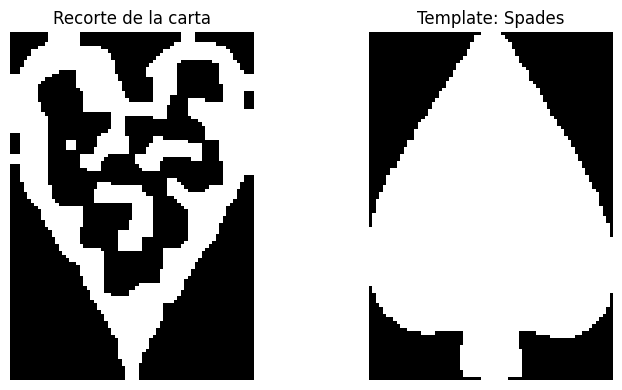

Spades: score = -0.0277


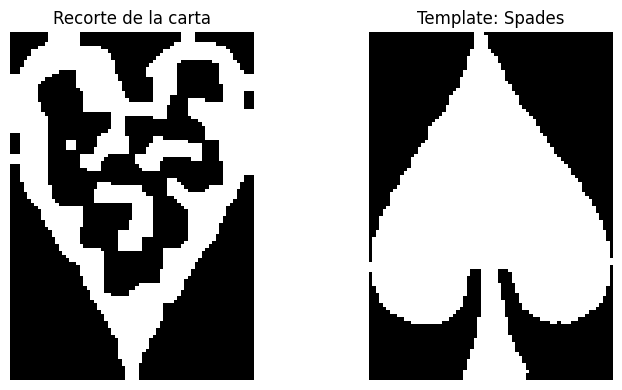

Spades: score = -0.0069
🃏 Card detected: Two of Hearts


('Two', 'Hearts')

In [20]:
main("Fotos/Imagenes/2H27.jpg", debug=True)

Detectando edges


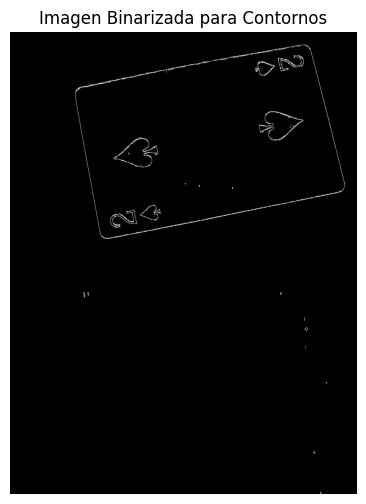

Buscando los contornos de cartas


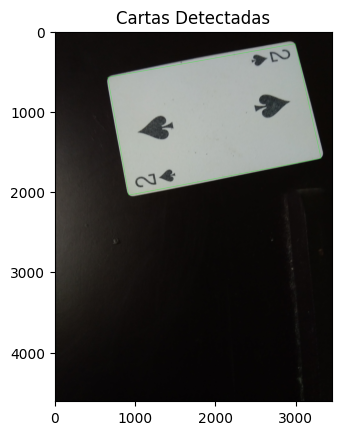

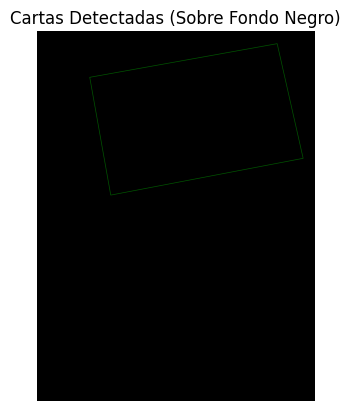

Analizando las cartas


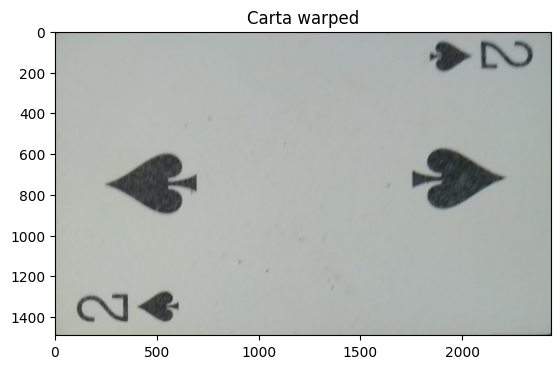

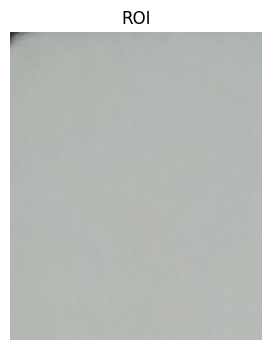

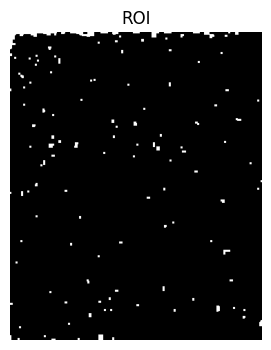

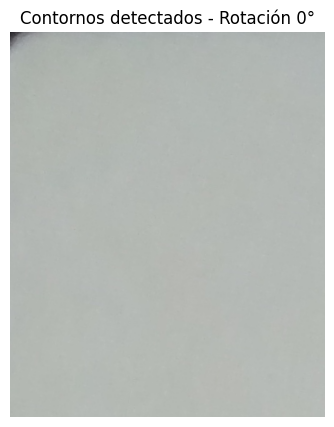

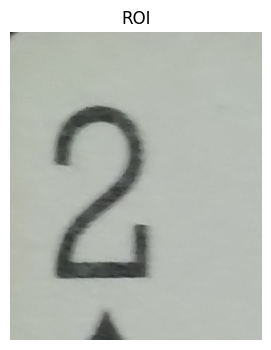

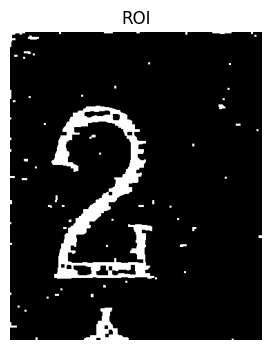

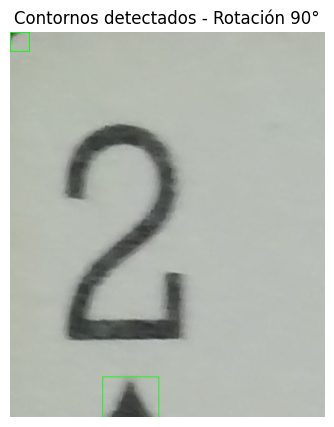

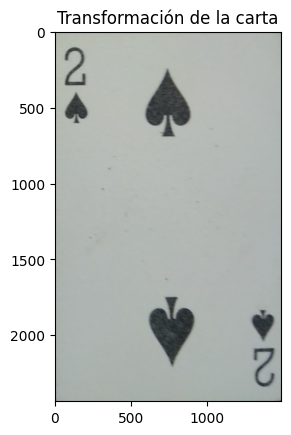

[DEBUG] Dimensiones carta: 1490x2435 | Ratio: 1.63 | 0.30000000000000004 <= 1.63 <= 1.7
	Resultado:True


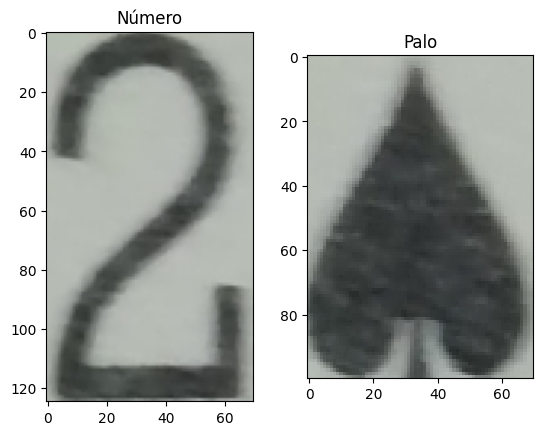

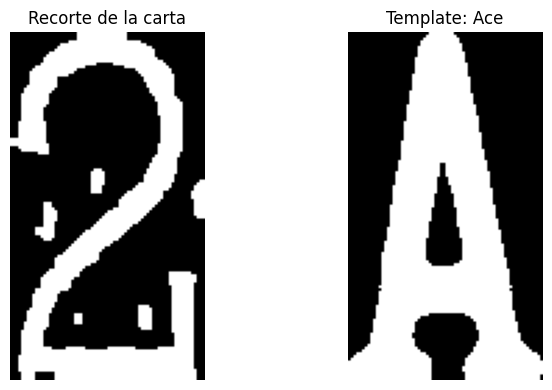

Ace: score = -0.0031


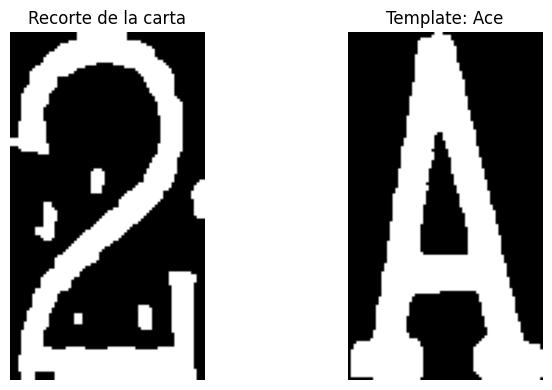

Ace: score = 0.0042


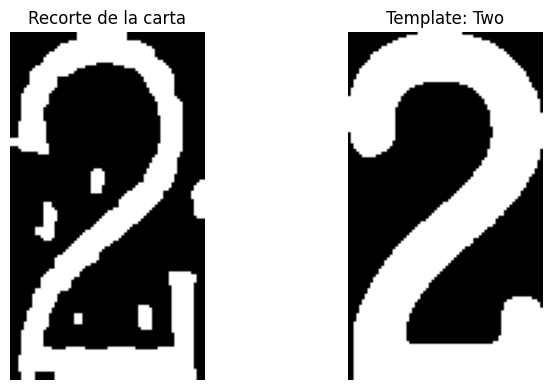

Two: score = 0.5566


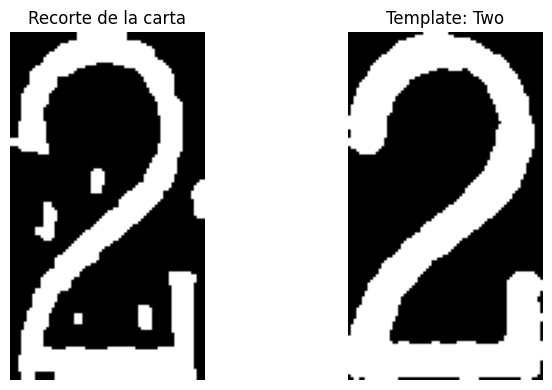

Two: score = 0.6977


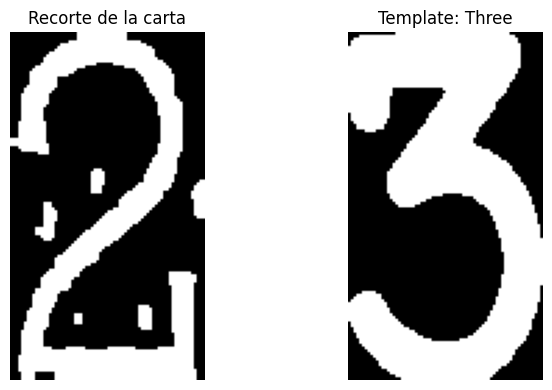

Three: score = 0.1602


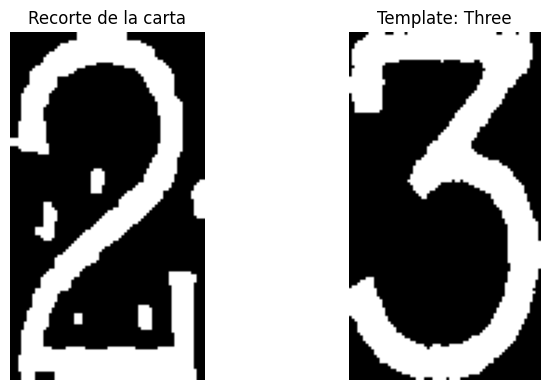

Three: score = 0.1726


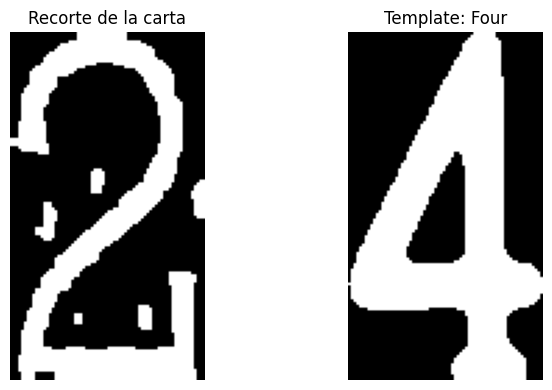

Four: score = -0.0494


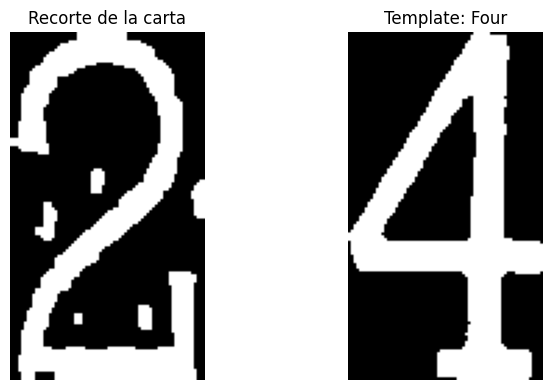

Four: score = 0.0069


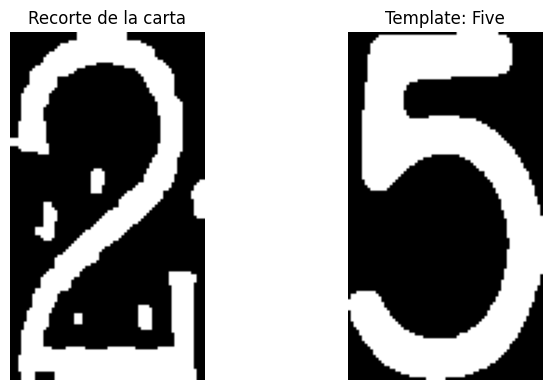

Five: score = 0.1791


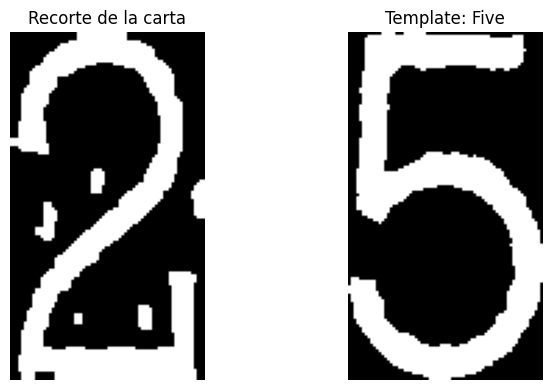

Five: score = 0.2222


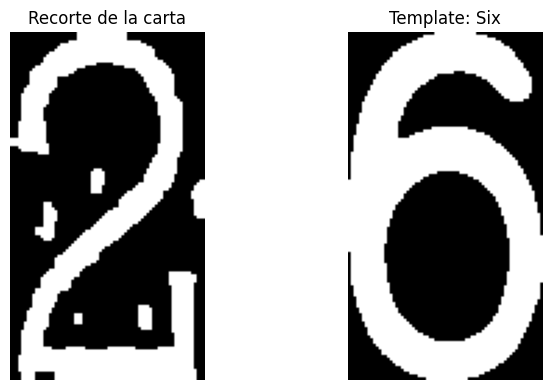

Six: score = 0.1456


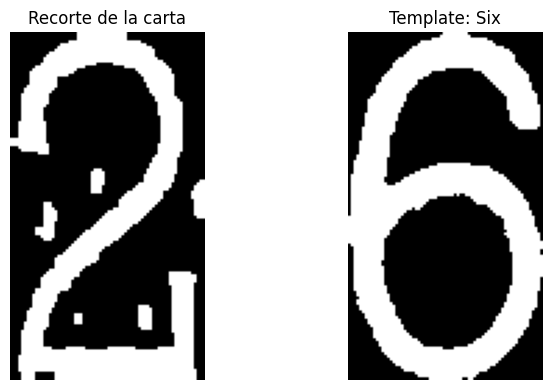

Six: score = 0.1904


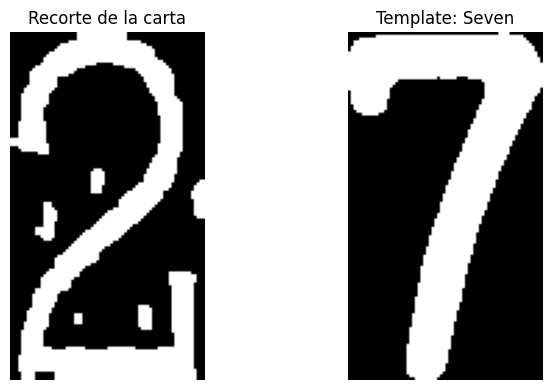

Seven: score = 0.1604


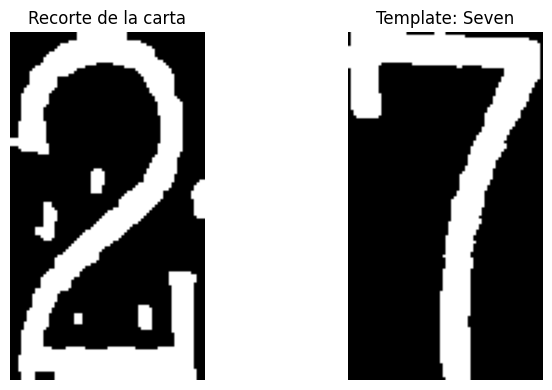

Seven: score = 0.1265


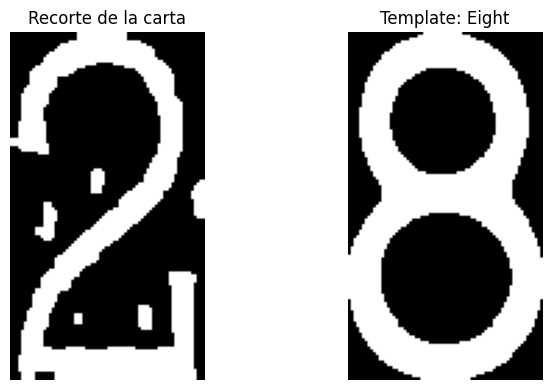

Eight: score = 0.3682


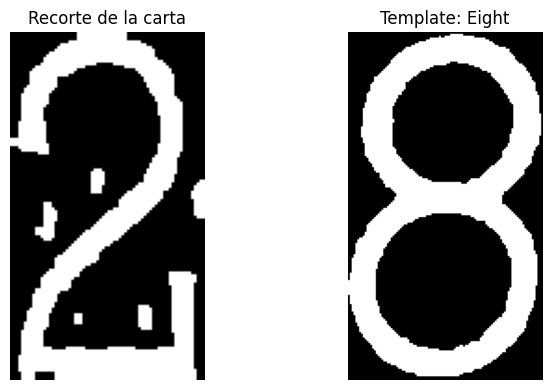

Eight: score = 0.2724


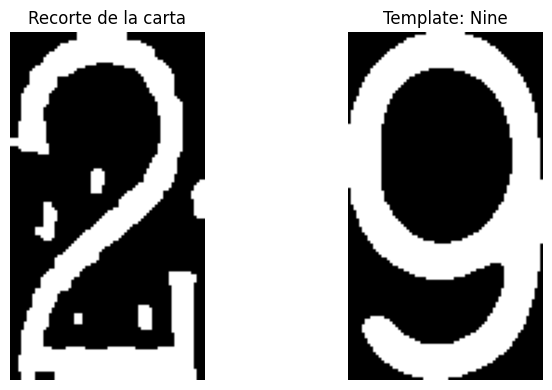

Nine: score = 0.2681


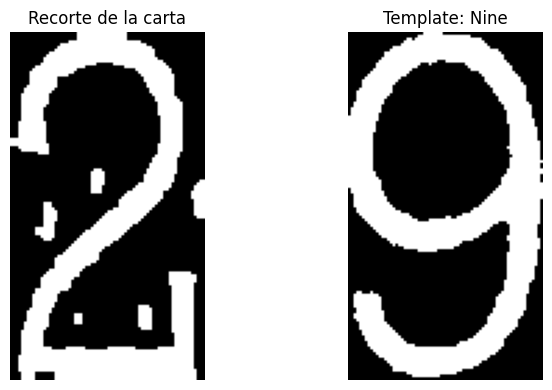

Nine: score = 0.3485


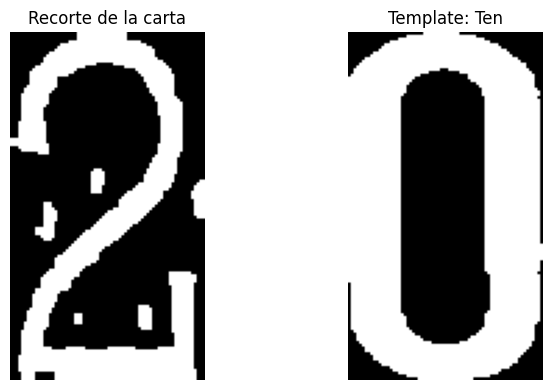

Ten: score = 0.2657


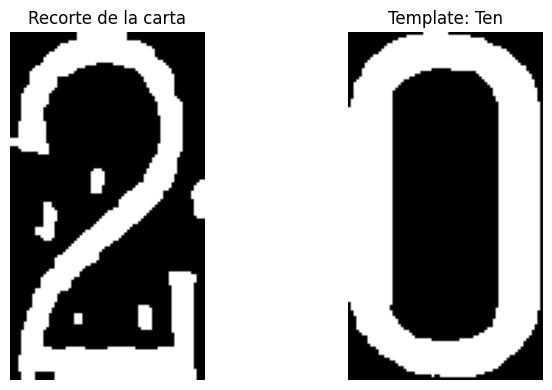

Ten: score = 0.2618


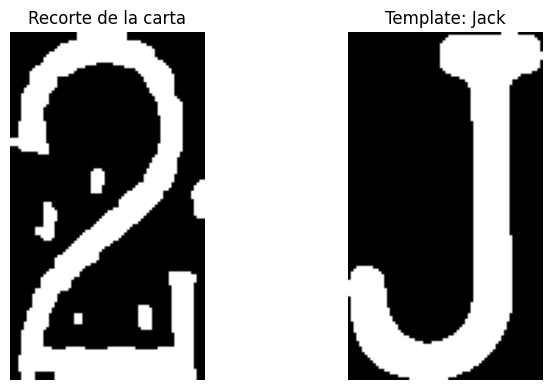

Jack: score = 0.1484


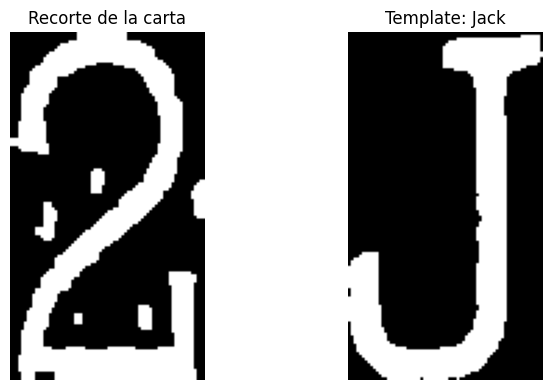

Jack: score = 0.1679


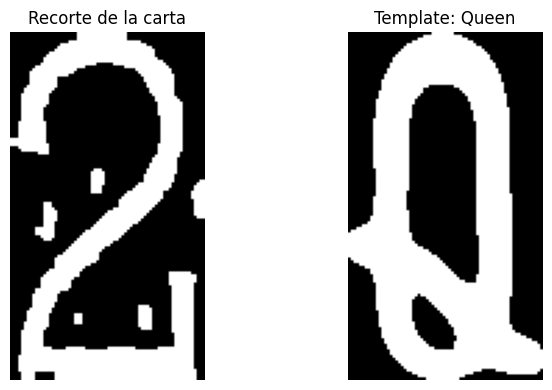

Queen: score = 0.1378


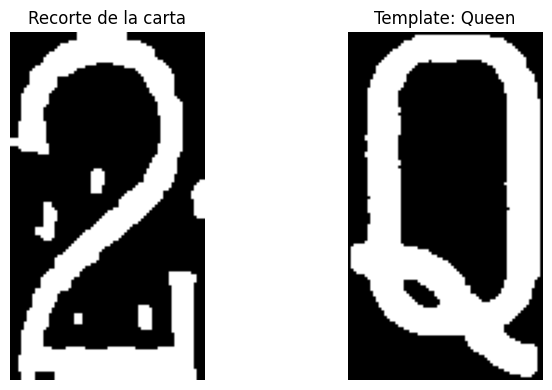

Queen: score = 0.0937


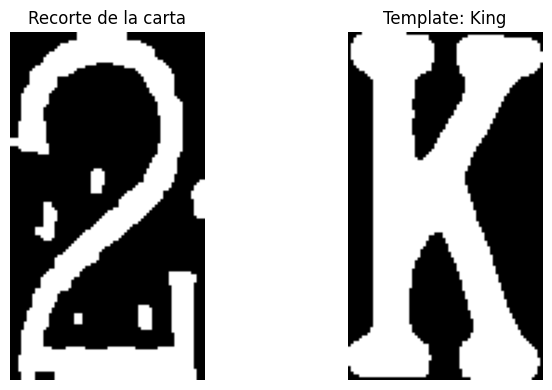

King: score = 0.1210


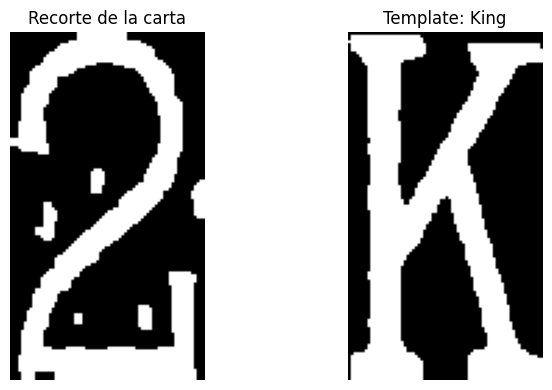

King: score = 0.1373


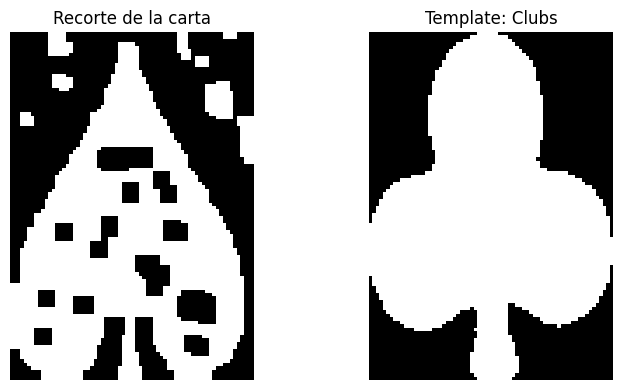

Clubs: score = 0.2889


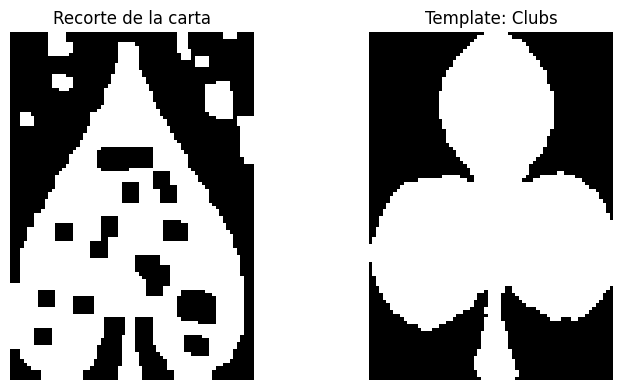

Clubs: score = 0.2734


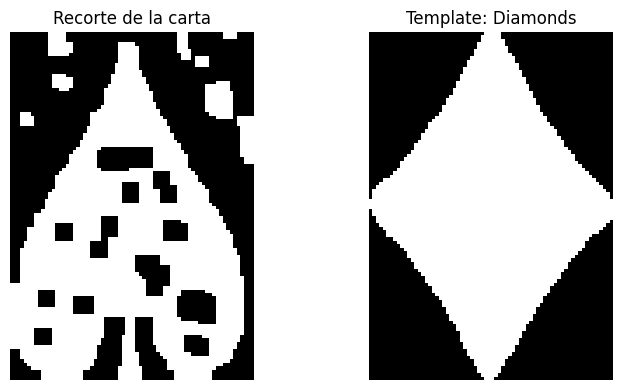

Diamonds: score = 0.2436


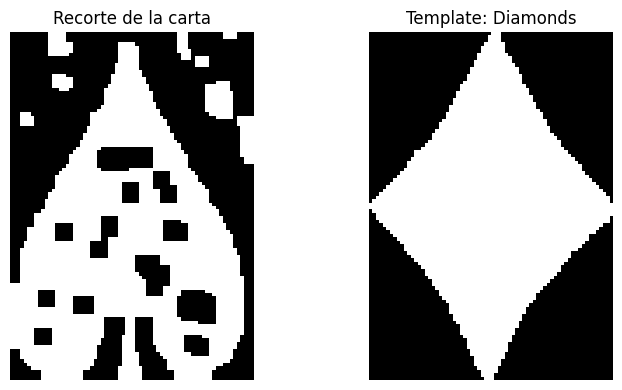

Diamonds: score = 0.2714


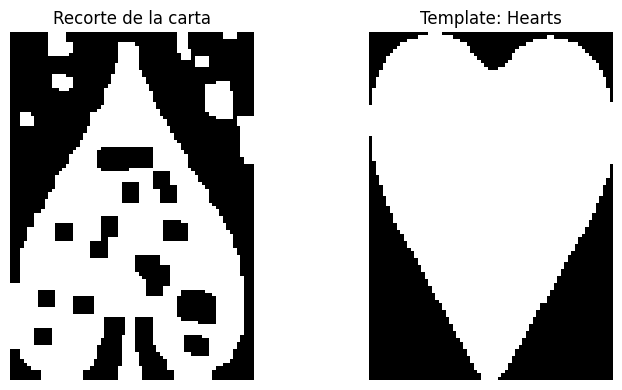

Hearts: score = -0.0168


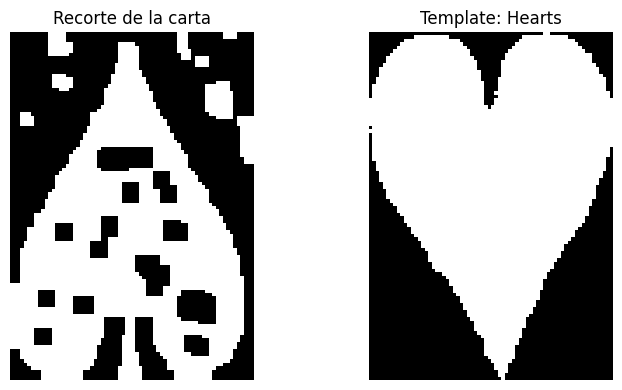

Hearts: score = -0.0694


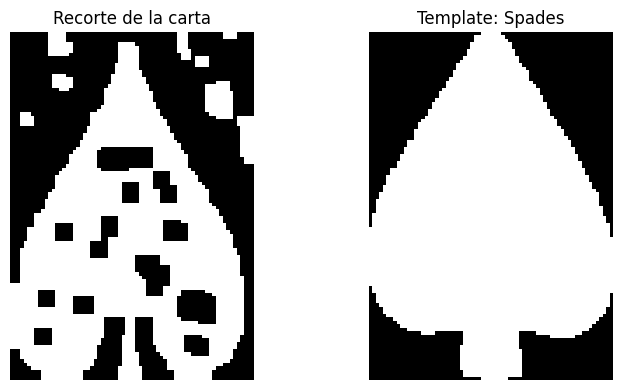

Spades: score = 0.2852


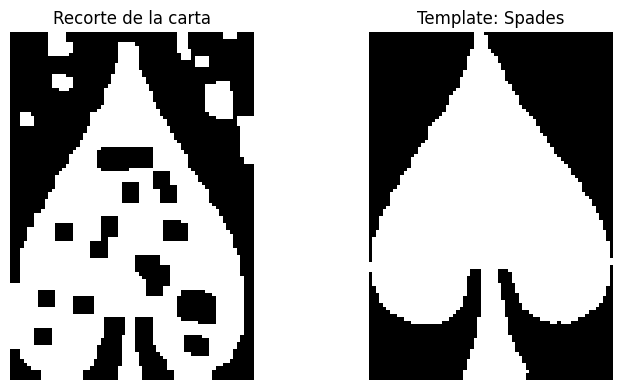

Spades: score = 0.3607
🃏 Card detected: Two of Spades


('Two', 'Spades')

In [21]:
main("Fotos/Imagenes/2S0.jpg", debug=True)

Detectando edges


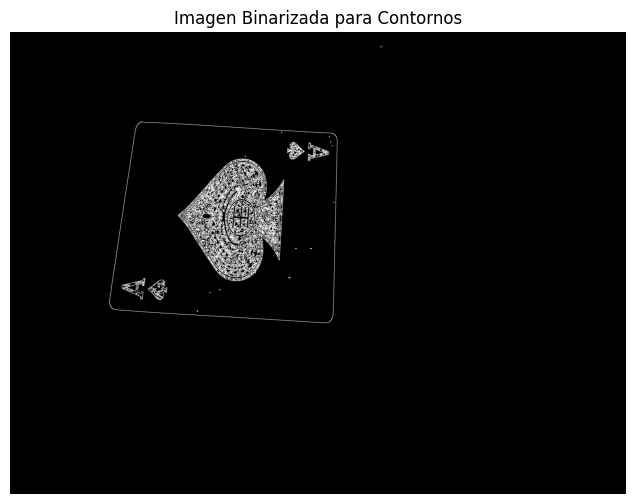

Buscando los contornos de cartas


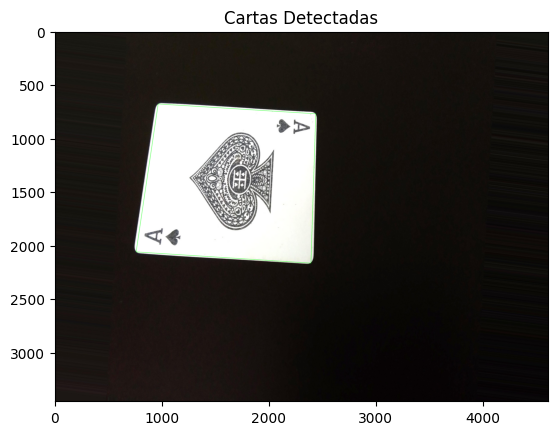

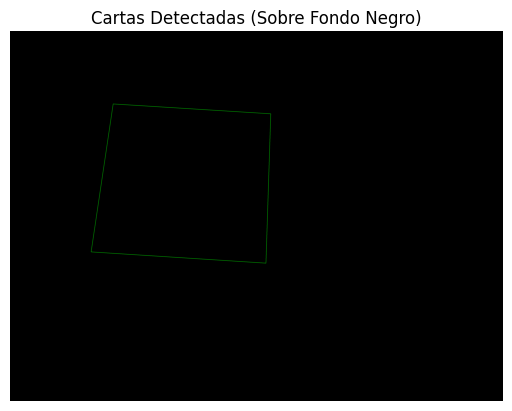

Analizando las cartas


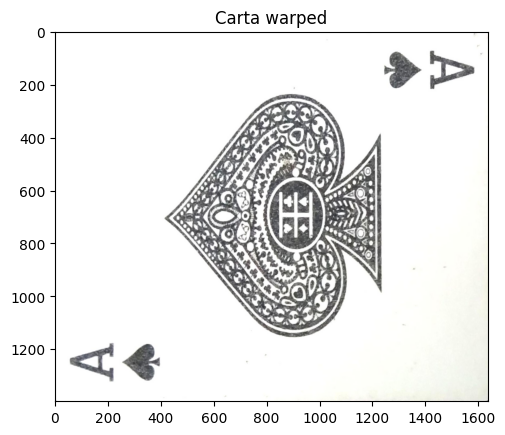

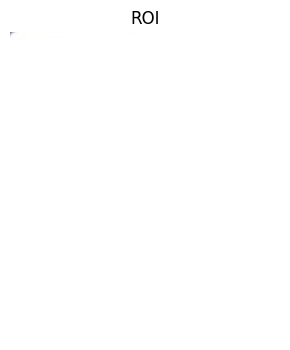

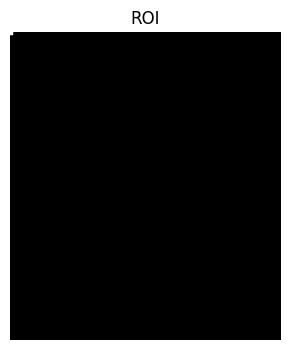

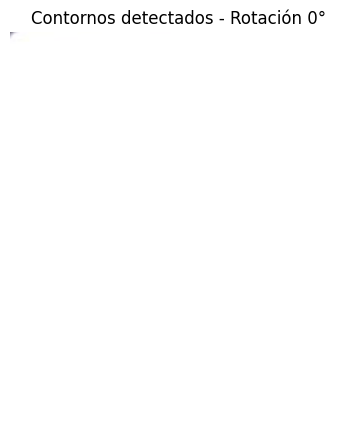

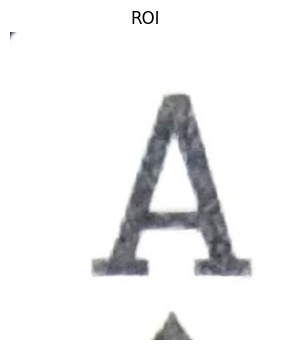

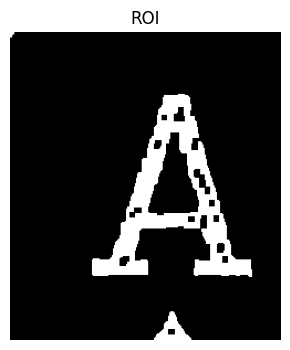

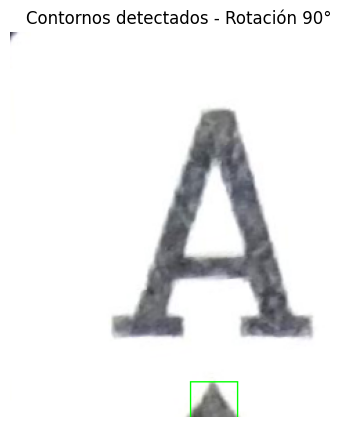

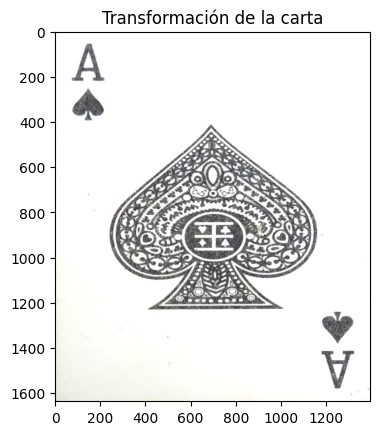

[DEBUG] Dimensiones carta: 1397x1637 | Ratio: 1.17 | 0.30000000000000004 <= 1.17 <= 1.7
	Resultado:True


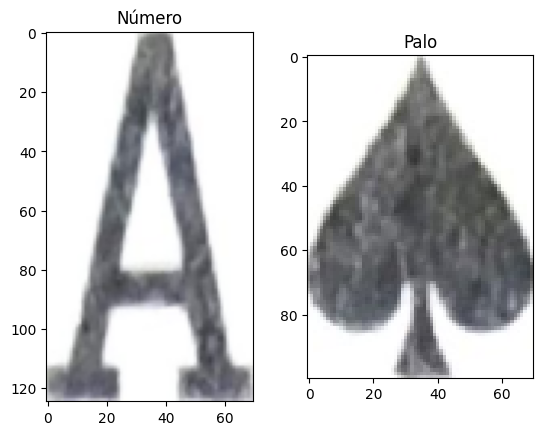

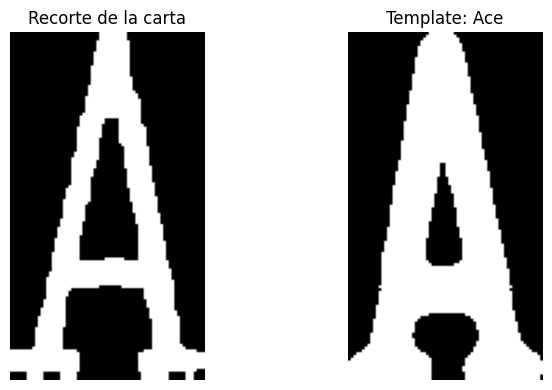

Ace: score = 0.6765


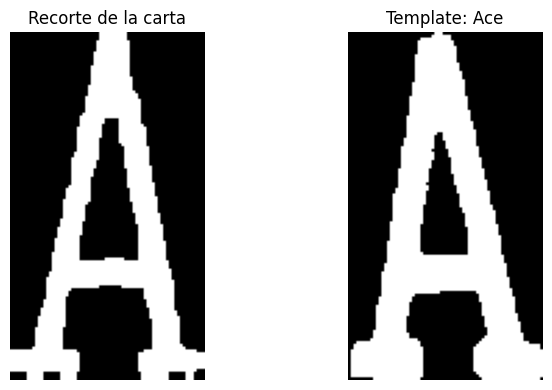

Ace: score = 0.7275


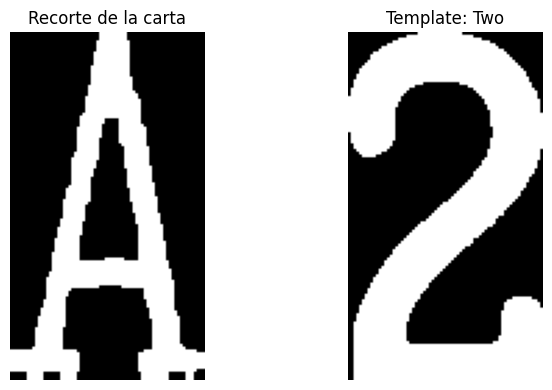

Two: score = 0.0341


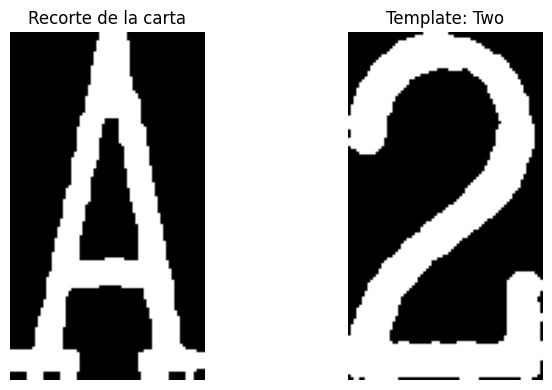

Two: score = 0.0213


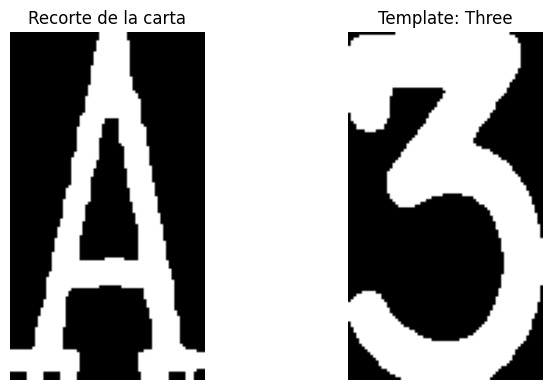

Three: score = 0.0779


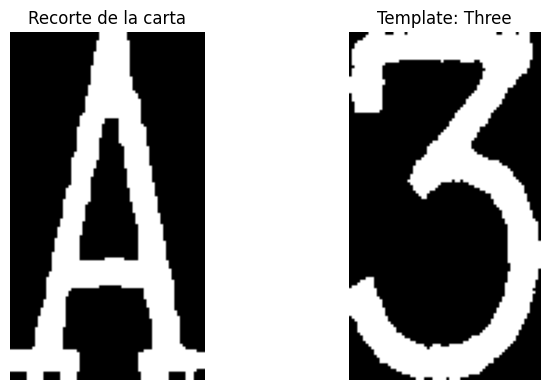

Three: score = -0.0461


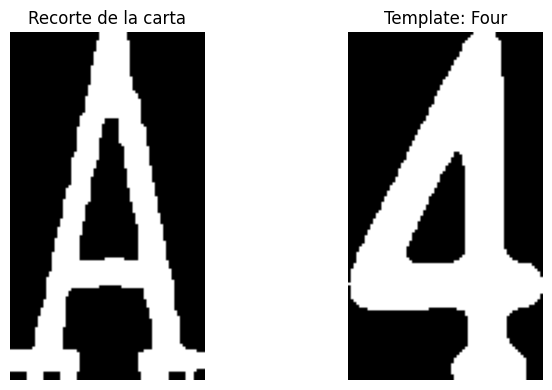

Four: score = 0.3846


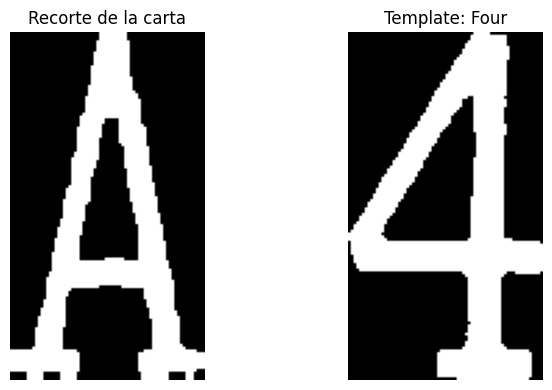

Four: score = 0.2080


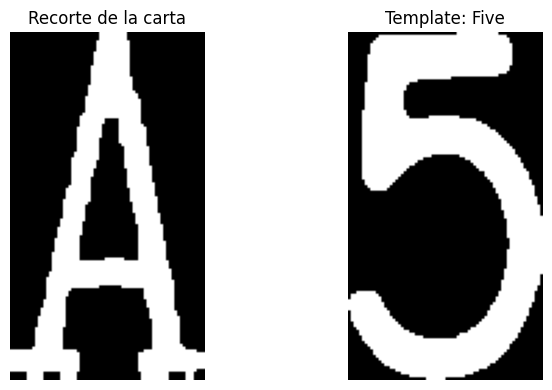

Five: score = -0.0732


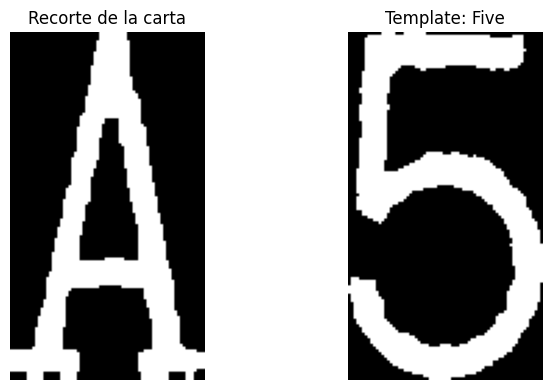

Five: score = -0.1055


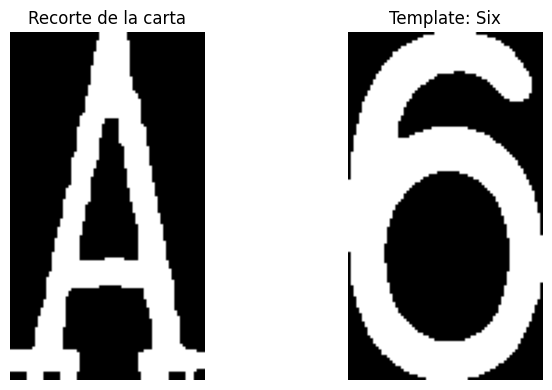

Six: score = -0.1484


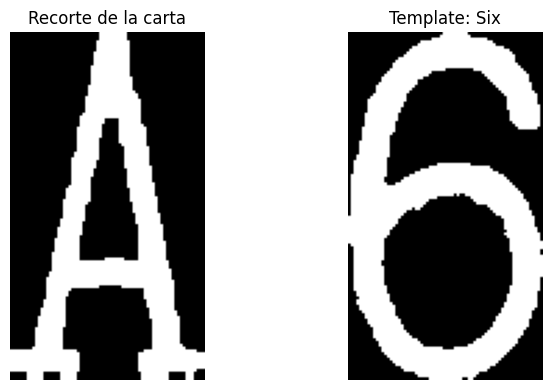

Six: score = -0.1299


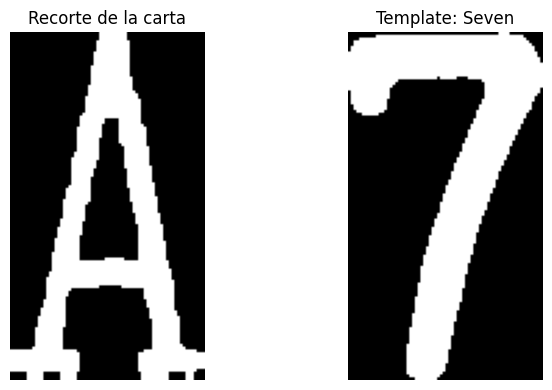

Seven: score = -0.1404


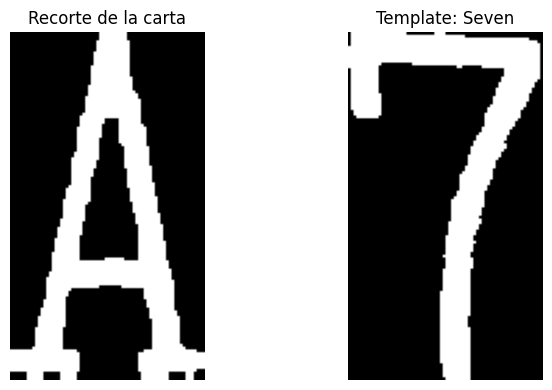

Seven: score = -0.1396


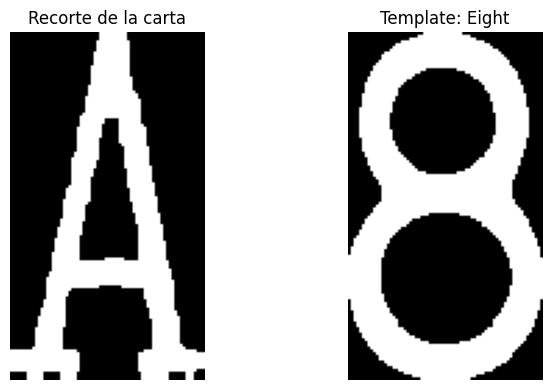

Eight: score = -0.1267


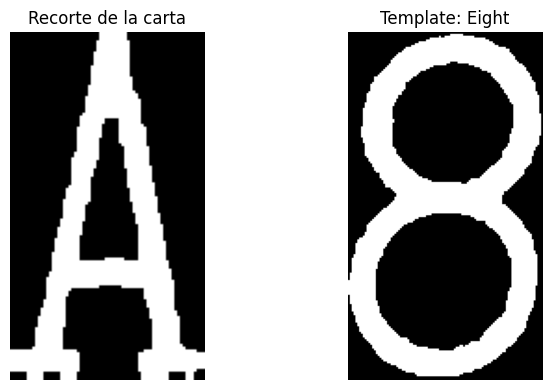

Eight: score = -0.1242


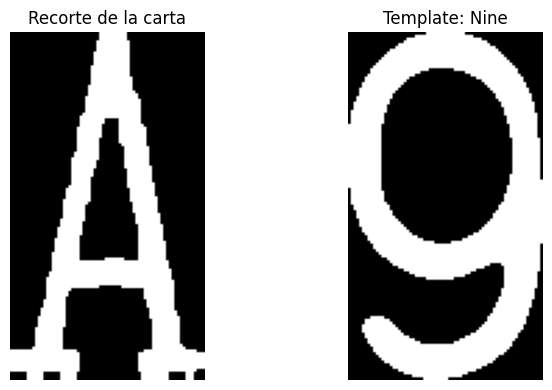

Nine: score = -0.0743


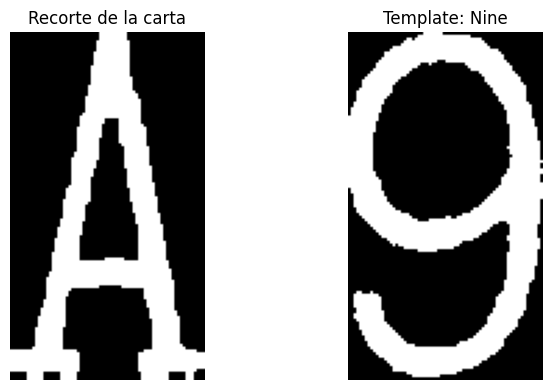

Nine: score = -0.1649


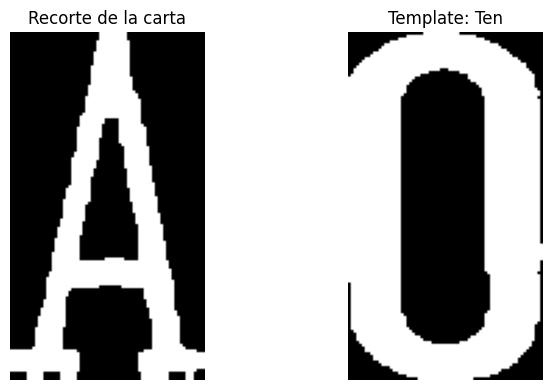

Ten: score = -0.2206


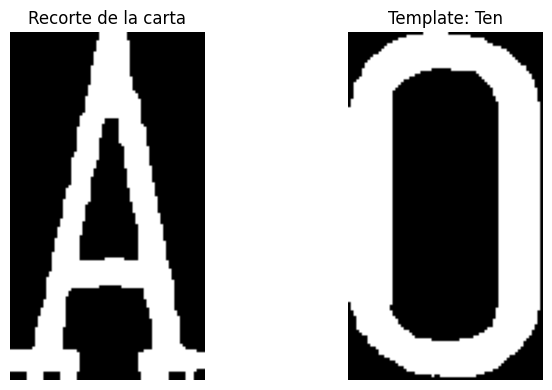

Ten: score = -0.2852


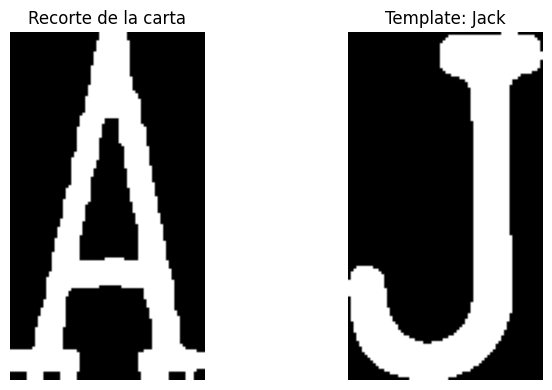

Jack: score = 0.1297


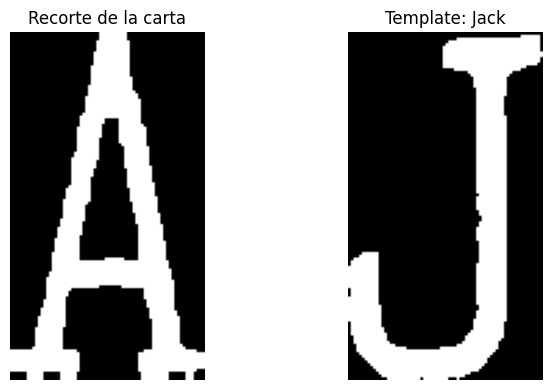

Jack: score = 0.0956


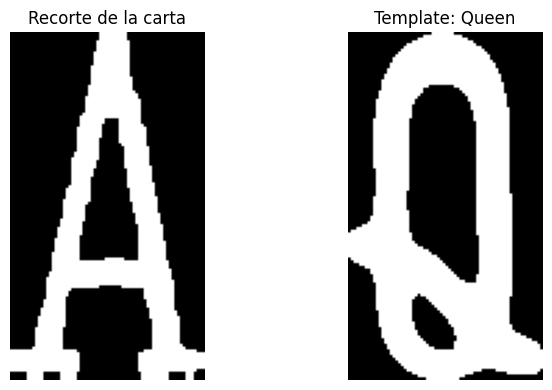

Queen: score = 0.1906


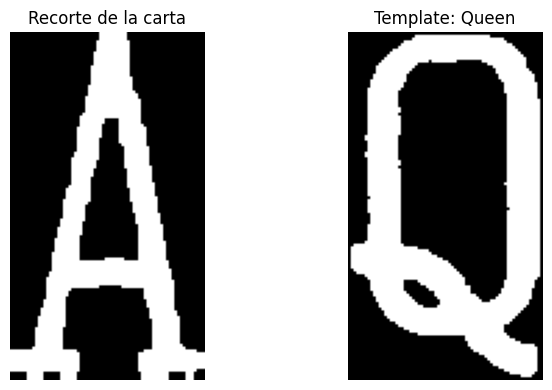

Queen: score = -0.1440


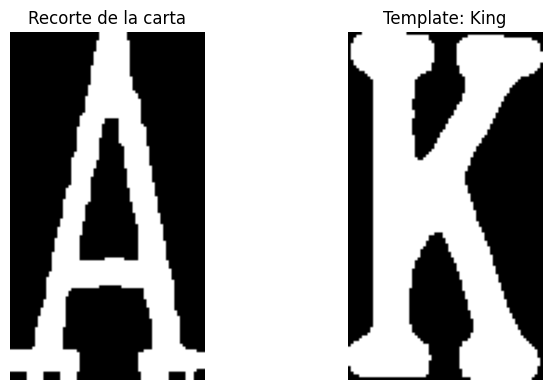

King: score = 0.1418


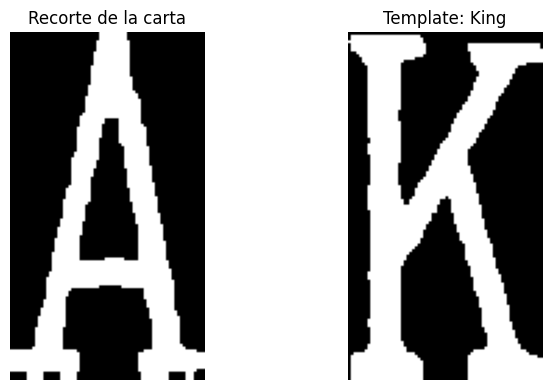

King: score = 0.1766


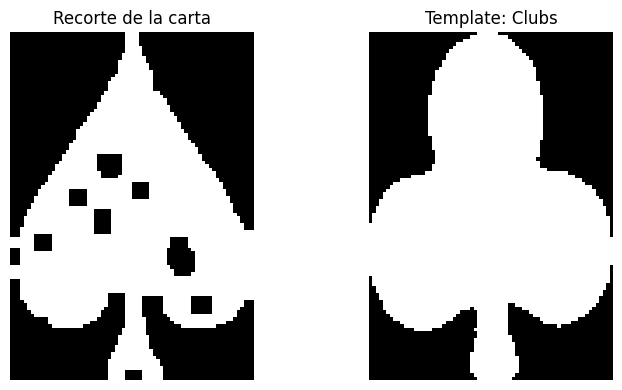

Clubs: score = 0.7226


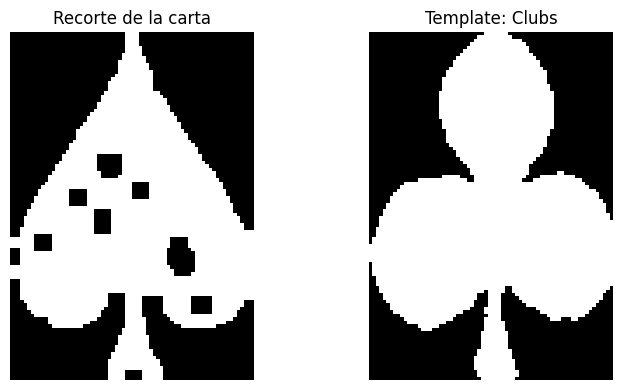

Clubs: score = 0.7042


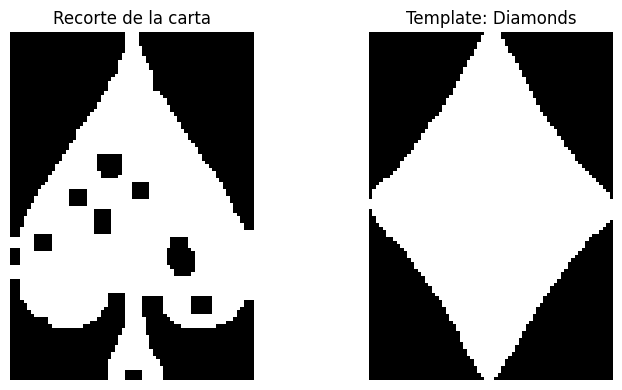

Diamonds: score = 0.5508


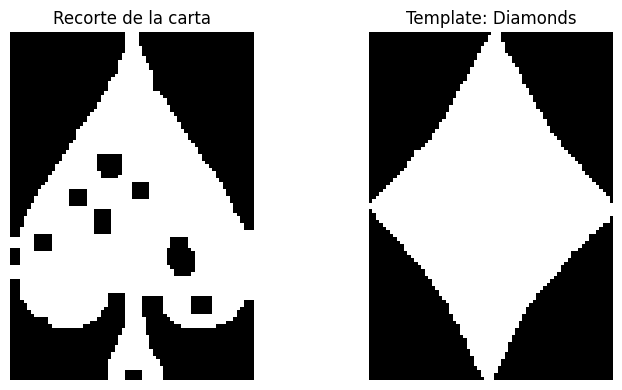

Diamonds: score = 0.5766


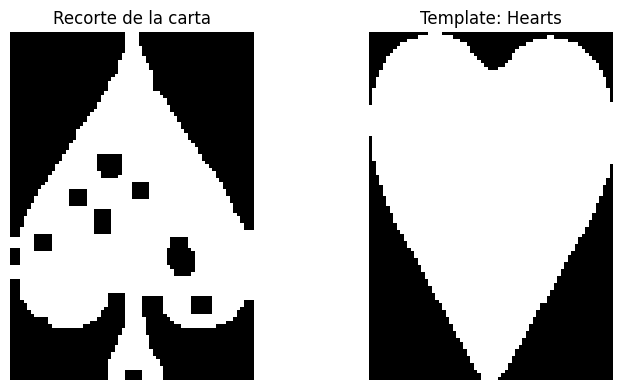

Hearts: score = 0.1671


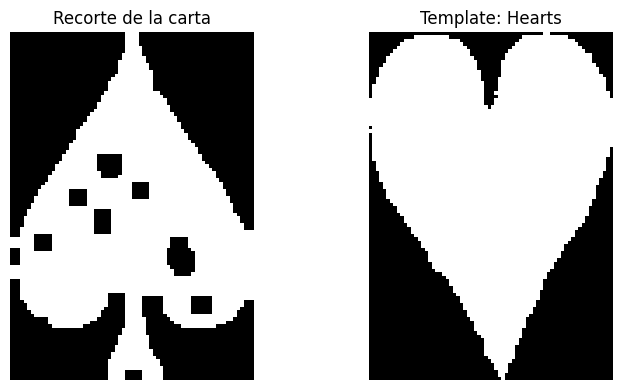

Hearts: score = 0.0988


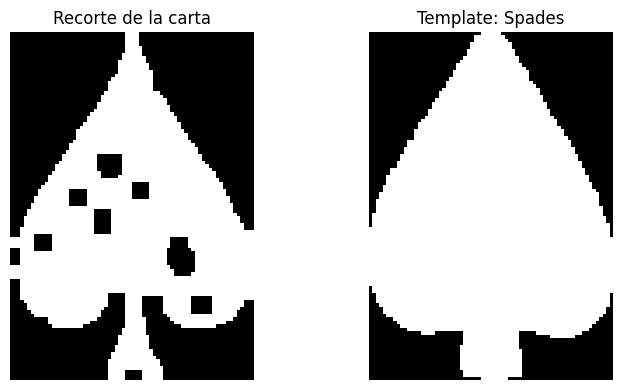

Spades: score = 0.7070


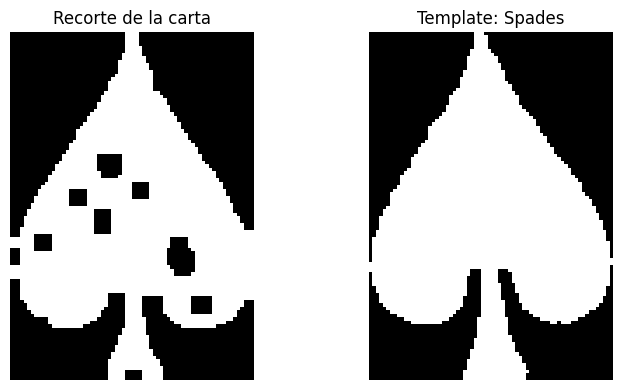

Spades: score = 0.8073
🃏 Card detected: Ace of Spades


('Ace', 'Spades')

In [25]:
main("Fotos/Imagenes/AS1.jpg", debug=True)

In [55]:
import os
import re
import sys

suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

def extraer_datos(nombre):
    match = re.match(r"(\w+)([A-Z])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

# Generar combinaciones: cada carta en 3 posiciones
for number_name, number_symbol in numbers.items():
    for suit_name, suit_symbol in suits.items():
        for i in range(2):  # 3 posiciones por carta
            filename = f"{number_symbol}{suit_symbol}{i}.jpg"
            ruta_completa = os.path.join("Fotos", "Imagenes", filename)
            if not os.path.exists(ruta_completa):
                print(f"⚠️ Archivo no encontrado: {ruta_completa}")
                continue
            print("Archivo:", filename)
            print("-" * 100)

            number, suit = main(ruta_completa)  # tu función real de predicción
            number_prediction, suit_prediction = extraer_datos(filename)
            
            if suit is None or number is None:
                print("❌ No se pudo predecir")
                succession.append(False)
            else:
                if suits[suit] == suit_prediction and numbers[number] == number_prediction:
                    print("✅ Acierto")
                    succession.append(True)
                else:
                    print("❌ Fallo")
                    succession.append(False)

            print("=" * 100)

# Calcular totales
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

# Calcular porcentajes
porcentaje_aciertos = (aciertos / total) * 100
porcentaje_fallos = (fallos / total) * 100

print(f"\nResumen final:")
print(f"Aciertos: {porcentaje_aciertos:.2f}%")
print(f"Fallos: {porcentaje_fallos:.2f}%")


Archivo: AC0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: AC1.jpg
----------------------------------------------------------------------------------------------------


C:\Users\migue\AppData\Local\Temp\ipykernel_30020\4193457069.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


✅ Acierto
Archivo: AD0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: AD1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: AH0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: AH1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: AS0.jpg
----------------------------------------------------------------------------------------------------
❌ No se pudo predecir
Archivo: AS1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 2C0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: 2C1.jpg
-----------------------------------------------------------------------

❌ Fallo
Archivo: 5S0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 5S1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 6C0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 6C1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 6D0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 6D1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 6H0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: 6H1.jpg
-------------------------------------------------------------------------------------------

✅ Acierto
Archivo: 10D0.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: 10D1.jpg
----------------------------------------------------------------------------------------------------
❌ No se pudo predecir
Archivo: 10H0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 10H1.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 10S0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: 10S1.jpg
----------------------------------------------------------------------------------------------------
✅ Acierto
Archivo: JC0.jpg
----------------------------------------------------------------------------------------------------
❌ Fallo
Archivo: JC1.jpg
-------------------------------------------------------------------

In [36]:
import os
import re
from tqdm import tqdm  # ✅ Importar tqdm
# Asegúrate de tenerlo instalado: pip install tqdm

# Diccionarios de conversión
suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

reverse_suits = {v: k for k, v in suits.items()}
reverse_numbers = {v: k for k, v in numbers.items()}

def extraer_datos(nombre):
    match = re.match(r"([A2-9]|10|J|Q|K|T)([CDHS])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None

succession = []

carpeta = os.path.join("Fotos", "Imagenes")
archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(".jpg")]

# ✅ Añadir barra de progreso
for filename in tqdm(archivos, desc="Procesando imágenes"):
    ruta_completa = os.path.join(carpeta, filename)

    number, suit = main(ruta_completa)  # tu función de predicción

    number_prediction, suit_prediction = extraer_datos(filename)

    if suit is None or number is None:
        # print(f"❌ {filename} → No se pudo predecir")
        succession.append(False)
    else:
        try:
            match_number = numbers[number]
            match_suit = suits[suit]

            if match_number == number_prediction and match_suit == suit_prediction:
                succession.append(True)
            else:
                succession.append(False)
        except KeyError:
            succession.append(False)

# === RESUMEN FINAL ===
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

porcentaje_aciertos = (aciertos / total) * 100 if total > 0 else 0
porcentaje_fallos = (fallos / total) * 100 if total > 0 else 0

print(f"\nResumen final:")
print(f"Total imágenes: {total}")
print(f"Aciertos: {aciertos} ({porcentaje_aciertos:.2f}%)")
print(f"Fallos: {fallos} ({porcentaje_fallos:.2f}%)")


Procesando imágenes:   0%|▏                                                          | 11/2706 [00:04<19:50,  2.26it/s]C:\Users\migue\AppData\Local\Temp\ipykernel_30020\891892584.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
Procesando imágenes:   5%|██▊                                                       | 131/2706 [01:01<21:47,  1.97it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.
⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:   5%|███                                                       | 141/2706 [01:06<22:14,  1.92it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:   6%|███▎                                                      | 152/2706 [01:11<21:46,  1.95it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:   8%|████▉                                                     | 228/2706 [01:50<21:11,  1.95it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  18%|██████████▎                                               | 484/2706 [03:55<19:27,  1.90it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  55%|███████████████████████████████▎                         | 1488/2706 [12:12<10:02,  2.02it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  68%|██████████████████████████████████████▊                  | 1840/2706 [15:12<07:35,  1.90it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  84%|███████████████████████████████████████████████▉         | 2278/2706 [19:14<03:56,  1.81it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  89%|██████████████████████████████████████████████████▊      | 2413/2706 [20:33<02:33,  1.91it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  90%|███████████████████████████████████████████████████▎     | 2438/2706 [20:46<02:19,  1.92it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  91%|███████████████████████████████████████████████████▊     | 2458/2706 [20:56<02:08,  1.92it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.
⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  91%|███████████████████████████████████████████████████▊     | 2460/2706 [20:57<02:13,  1.85it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  92%|████████████████████████████████████████████████████▏    | 2480/2706 [21:08<02:06,  1.79it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.
⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes:  92%|████████████████████████████████████████████████████▎    | 2483/2706 [21:10<01:57,  1.89it/s]

⚠️ ROI vacío. No se puede convertir a escala de grises.


Procesando imágenes: 100%|█████████████████████████████████████████████████████████| 2706/2706 [23:18<00:00,  1.93it/s]


Resumen final:
Total imágenes: 2706
Aciertos: 1039 (38.40%)
Fallos: 1667 (61.60%)
